# Capstone Project: Sentiment Analysis on Airbnb Reviews and Price Prediction

### Contents:
- [Data Cleaning (Listings)](#Data-Cleaning-(Listings))
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Feature Selection](#Feature-Selection)
- [EDA Summary](#EDA-Summary)

## Data Cleaning (Listings)

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings

from datetime import datetime
import regex as re
from PIL import Image

warnings.filterwarnings('ignore')
sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Import data

In [2]:
listings = pd.read_csv('../data/detailed_listings.csv')
listings.shape

(7323, 106)

In [3]:
listings.head()

id                         listing_url       scrape_id last_scraped  \
0  49091  https://www.airbnb.com/rooms/49091  20200622052726   2020-06-22   
1  50646  https://www.airbnb.com/rooms/50646  20200622052726   2020-06-22   
2  56334  https://www.airbnb.com/rooms/56334  20200622052726   2020-06-23   
3  71609  https://www.airbnb.com/rooms/71609  20200622052726   2020-06-23   
4  71896  https://www.airbnb.com/rooms/71896  20200622052726   2020-06-23   

                                  name  \
0    COZICOMFORT LONG TERM STAY ROOM 2   
1      Pleasant Room along Bukit Timah   
2                          COZICOMFORT   
3  Ensuite Room (Room 1 & 2) near EXPO   
4      B&B  Room 1 near Airport & EXPO   

                                             summary  \
0                                                NaN   
1  Fully furnished bedroom with a nice view on th...   
2                                                NaN   
3  For 3 (Website hidden by Airbnb) room 1&2 and ...   
4                                                NaN   

                                               space  \
0  This is Room No. 2.(available after Jan 15 201...   
1  Good Condition room, bright & windy. Comes wit...   
2  This is Room no. 1. USD700 per month On the fa...   
3  Landed Homestay Room for Rental. Between Simei...   
4  Vocational Stay Deluxe Bedroom in Singapore.(N...   

                                         description experiences_offered  \
0  This is Room No. 2.(available after Jan 15 201...                none   
1  Fully furnished bedroom with a nice view on th...                none   
2  This is Room no. 1. USD700 per month On the fa...                none   
3  For 3 (Website hidden by Airbnb) room 1&2 and ...                none   
4  Vocational Stay Deluxe Bedroom in Singapore.(N...                none   

                               neighborhood_overview  \
0                                                NaN   
1  The serenity & quiet surrounding makes it an i...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                               notes  \
0                                                NaN   
1  Accommodation has a queen size bed.  Suitable ...   
2                                                NaN   
3  Incase there is some changes in the rooms allo...   
4  Incase there is some changes in the rooms allo...   

                                             transit  \
0                                                NaN   
1  Less than 400m from the apartment is the main ...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                              access  \
0                                                NaN   
1  Kitchen, washing facilities, gym, swimming poo...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         interaction  \
0                                                NaN   
1  We love to host people & have the opportunity ...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         house_rules  thumbnail_url  \
0  No smoking indoors. Please turn off lights/fan...            NaN   
1  '- Should be family friendly. '- Cooking is no...            NaN   
2  No smoking indoors. Please turn off lights/air...            NaN   
3  Home Stay Rules  House Rules & Check in Requir...            NaN   
4  Vocational Stay Rules  - Do not excessively me...            NaN   

   medium_url                                  

In [4]:
len(listings['id'].unique())

7323

In [5]:
# create a list of tuples to contain dataframe and name
dfs = [(listings ,'listings')]

# print some basic information for each dataframe 
# number of rows and columns
# datatype and number of null values for each column in the dataframe

def basic_eda(df, name):
    print(f"""-----------------------------------------------\n
{name} dataframe \n
Rows: {df.shape[0]}             Columns: {df.shape[1]}
Duplicated rows: {(df.duplicated(keep=False) == True).sum()}
Columns:
{pd.concat([pd.DataFrame(data=df.dtypes, columns=['data_type']),
         pd.DataFrame(data=df.isnull().sum(), columns=['num_nulls'])], axis=1)}
    \n""")
print("DATAFRAMES INFORMATION")    

# call function    
[basic_eda(df, name) for (df,name) in dfs];

DATAFRAMES INFORMATION
-----------------------------------------------

listings dataframe 

Rows: 7323             Columns: 106
Duplicated rows: 0
Columns:
                                             data_type  num_nulls
id                                               int64          0
listing_url                                     object          0
scrape_id                                        int64          0
last_scraped                                    object          0
name                                            object          1
summary                                         object        324
space                                           object       1957
description                                     object        249
experiences_offered                             object          0
neighborhood_overview                           object       2933
notes                                           object       3315
transit                                         obj

### Drop initial columns

The dataset contains information on 7323 listings and 106 features, describing the different characteristics of each listing (features). There are a number of features with missing values in almost every listing, e.g. `square feet`, `weekly/ monthly price` etc, and replicated information in different columns e.g. `host listings count` and `host total listing counts`, as well as information not useful to predict price e.g. picture url columns and host related columns unrelated to the property. These columns will be dropped initially. 

Some text features such as `description`, `summary` and `transit` will be retained to help in inferring to fill missing values, and feature engineered to extract the text lengths which might be useful to predict the listing price. 

In [6]:
# Drop columns with majority of null values, replicated information and those not useful for predicting price.

cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'space', 'experiences_offered','neighborhood_overview',\
                'notes', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', \
                'xl_picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url',\
                'host_picture_url', 'host_neighbourhood', 'host_total_listings_count','host_verifications',\
                'host_has_profile_pic', 'street','neighbourhood','zipcode','city','state','market','smart_location','country_code',\
                'country','is_location_exact','square_feet','weekly_price','monthly_price','minimum_minimum_nights',\
                'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',\
                'maximum_nights_avg_ntm','calendar_updated','requires_license','license','jurisdiction_names',\
                'require_guest_profile_picture','require_guest_phone_verification','calendar_last_scraped',
                'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']
listings = listings.drop(cols_to_drop, axis=1)

In [7]:
listings.head()

id                                            summary  \
0  49091                                                NaN   
1  50646  Fully furnished bedroom with a nice view on th...   
2  56334                                                NaN   
3  71609  For 3 (Website hidden by Airbnb) room 1&2 and ...   
4  71896                                                NaN   

                                         description  \
0  This is Room No. 2.(available after Jan 15 201...   
1  Fully furnished bedroom with a nice view on th...   
2  This is Room no. 1. USD700 per month On the fa...   
3  For 3 (Website hidden by Airbnb) room 1&2 and ...   
4  Vocational Stay Deluxe Bedroom in Singapore.(N...   

                                             transit  host_id  host_since  \
0                                                NaN   266763  2010-10-20   
1  Less than 400m from the apartment is the main ...   227796  2010-09-08   
2                                                NaN   266763  2010-10-20   
3                                                NaN   367042  2011-01-29   
4                                                NaN   367042  2011-01-29   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour               100%                  NaN   
1                NaN                NaN                  NaN   
2     within an hour               100%                  NaN   
3     within an hour               100%                 100%   
4     within an hour               100%                 100%   

  host_is_superhost  host_listings_count host_identity_verified  \
0                 f                  2.0                      f   
1                 f                  1.0                      f   
2                 f                  2.0                      f   
3                 f                  8.0                      t   
4                 f                  8.0                      t   

  neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  \
0              Woodlands                 North Region   1.44255  103.79580   
1            Bukit Timah               Central Region   1.33235  103.78521   
2              Woodlands                 North Region   1.44246  103.79667   
3               Tampines                  East Region   1.34541  103.95712   
4               Tampines                  East Region   1.34567  103.95963   

  property_type     room_type  accommodates  bathrooms  bedrooms  beds  \
0     Apartment  Private room             1        1.0       1.0   1.0   
1     Apartment  Private room             2        1.0       1.0   1.0   
2     Apartment  Private room             1        1.0       1.0   1.0   
3         Villa  Private room             6        1.0       2.0   3.0   
4         House  Private room             3        0.5       1.0   1.0   

   bed_type                                          amenities    price  \
0  Real Bed  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   $84.00   
1  Real Bed  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   $80.00   
2  Real Bed  {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...   $70.00   
3  Real Bed  {TV,Wifi,"Air conditioning",Kitchen,"Pets live...  $167.00   
4  Real Bed  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...   $95.00   

  security_deposit cleaning_fee  guests_included extra_people  minimum_nights  \
0              NaN          NaN                1       $14.00             180   
1              NaN          NaN                2       $20.00              90   
2              NaN          NaN                1       $14.00               6   
3          $279.00       $56.00                4       $28.00              90   
4          $139.00       $28.00                1       $21.00              90   

   maximum_nights has_availability  availability_30  availability_60  \
0             360                t               30               60   
1             730                t         

In [7]:
# Check difference between 'hosting listings count' and 'calculated host listings count'
print(sum((listings.host_listings_count == listings.calculated_host_listings_count) == False))
listings.loc[((listings.host_listings_count == listings.calculated_host_listings_count) == False)][:3]

4232


id                                            summary  \
7  241503  Stay in a large house with ample living room s...   
8  241508  Stay in a large house with ample living room s...   
9  275343  Awesome location and host  Room near INSEAD, N...   

                                         description  \
7  Stay in a large house with ample living room s...   
8  Stay in a large house with ample living room s...   
9  Awesome location and host  Room near INSEAD, N...   

                                             transit  host_id  host_since  \
7  MRT/Subway/metro: I am located three minutes b...  1017645  2011-08-25   
8  MRT/Subway/metro: I am located three minutes b...  1017645  2011-08-25   
9                      2 minutes walk to bus station  1439258  2011-11-24   

  host_response_time host_response_rate host_acceptance_rate  \
7     within an hour               100%                 100%   
8     within an hour               100%                 100%   
9       within a day                50%                  76%   

  host_is_superhost  host_listings_count host_identity_verified  \
7                 t                  4.0                      t   
8                 t                  4.0                      t   
9                 f                  3.0                      f   

  neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  \
7                  Bedok                  East Region   1.32391  103.91277   
8                  Bedok                  East Region   1.32391  103.91277   
9            Bukit Merah               Central Region   1.28875  103.80814   

  property_type     room_type  accommodates  bathrooms  bedrooms  beds  \
7     Townhouse  Private room             1        1.0       1.0   1.0   
8     Townhouse  Private room             2        1.0       1.0   2.0   
9     Apartment  Private room             1        NaN       1.0   1.0   

   bed_type                                          amenities   price  \
7  Real Bed  {TV,"Cable TV",Internet,Wifi,"Air conditioning...  $52.00   
8  Real Bed  {TV,"Cable TV",Internet,Wifi,"Air conditioning...  $54.00   
9  Real Bed  {TV,Wifi,"Air conditioning","Wheelchair access...  $49.00   

  security_deposit cleaning_fee  guests_included extra_people  minimum_nights  \
7          $200.00        $0.00                1        $0.00              90   
8          $200.00        $0.00                1        $0.00              90   
9          $152.00       $65.00                1        $0.00              14   

   maximum_nights has_availability  availability_30  availability_60  \
7            1125                t               21               51   
8            1125                t               18               48   
9             999                t               29               59   

   availability_90  availability_365  number_of_reviews  \
7               81               356                176   
8               78               353                199   
9               89               364                 20   

   number_of_reviews_ltm first_review last_review  review_scores_rating  \
7                      2   2012-01-19  2020-02-06                  99.0   
8                      1   2011-11-02  2019-09-21                  99.0   
9                      2   2013-04-20  2020-04-17                  88.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
7                    10.0                       10.0                   10.0   
8                    10.0                       10.0                   10.0   
9                     8.0                        8.0                    9.0   

   review_scores_communication  review_scores_location  review_scores_value  \
7                         10.0                    10.0                 10.0   
8                         10.0                    10.0                 10.0   
9                          9.0                     9.0                  9.0  

In [9]:
# Check listing counts of a host id
len(listings[listings['host_id']==1017645])

3

In [8]:
# Drop 'host_listings_count' column as 'calculated_listings_count' reflects the actual listing counts
listings = listings.drop(columns='host_listings_count', axis=1)

In [11]:
listings.head()

id                                            summary  \
0  49091                                                NaN   
1  50646  Fully furnished bedroom with a nice view on th...   
2  56334                                                NaN   
3  71609  For 3 (Website hidden by Airbnb) room 1&2 and ...   
4  71896                                                NaN   

                                         description  \
0  This is Room No. 2.(available after Jan 15 201...   
1  Fully furnished bedroom with a nice view on th...   
2  This is Room no. 1. USD700 per month On the fa...   
3  For 3 (Website hidden by Airbnb) room 1&2 and ...   
4  Vocational Stay Deluxe Bedroom in Singapore.(N...   

                                             transit  host_id  host_since  \
0                                                NaN   266763  2010-10-20   
1  Less than 400m from the apartment is the main ...   227796  2010-09-08   
2                                                NaN   266763  2010-10-20   
3                                                NaN   367042  2011-01-29   
4                                                NaN   367042  2011-01-29   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour               100%                  NaN   
1                NaN                NaN                  NaN   
2     within an hour               100%                  NaN   
3     within an hour               100%                 100%   
4     within an hour               100%                 100%   

  host_is_superhost host_identity_verified neighbourhood_cleansed  \
0                 f                      f              Woodlands   
1                 f                      f            Bukit Timah   
2                 f                      f              Woodlands   
3                 f                      t               Tampines   
4                 f                      t               Tampines   

  neighbourhood_group_cleansed  latitude  longitude property_type  \
0                 North Region   1.44255  103.79580     Apartment   
1               Central Region   1.33235  103.78521     Apartment   
2                 North Region   1.44246  103.79667     Apartment   
3                  East Region   1.34541  103.95712         Villa   
4                  East Region   1.34567  103.95963         House   

      room_type  accommodates  bathrooms  bedrooms  beds  bed_type  \
0  Private room             1        1.0       1.0   1.0  Real Bed   
1  Private room             2        1.0       1.0   1.0  Real Bed   
2  Private room             1        1.0       1.0   1.0  Real Bed   
3  Private room             6        1.0       2.0   3.0  Real Bed   
4  Private room             3        0.5       1.0   1.0  Real Bed   

                                           amenities    price  \
0  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   $84.00   
1  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   $80.00   
2  {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...   $70.00   
3  {TV,Wifi,"Air conditioning",Kitchen,"Pets live...  $167.00   
4  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...   $95.00   

  security_deposit cleaning_fee  guests_included extra_people  minimum_nights  \
0              NaN          NaN                1       $14.00             180   
1              NaN          NaN                2       $20.00              90   
2              NaN          NaN                1       $14.00               6   
3          $279.00       $56.00                4       $28.00              90   
4          $139.00       $28.00                1       $21.00              90   

   maximum_nights has_availability  availability_30  availability_60  \
0             360                t               30               60   
1             730                t               30               60   
2              14                t               30               60   
3            1125        

### Data Dictionary

|Feature|Type|Dataset|Description|
|:---|:---|:---|:---|
|id            |int      |detailed_listings |listing id
|summary           |str      |detailed_listings |summary of listing characteristics
|description      |str |detailed_listings| detailed description of listing characteristics
|transit         |str      |detailed_listings| description of transport accessibility
|host_id        |int      |detailed_listings| host id
|host_since        |datetime      |detailed_listings| date that the host first joined Airbnb
|host_response_time          |str    |detailed_listings| average amount of time the host takes to reply to guest inquiries and booking requests
|host_response_rate          |str    |detailed_listings|  proportion of guest inquiries and booking requests that the host replies to
|host_acceptance_rate|str|detailed_listings| proportion of guest reservations that the host accepts
|host_is_superhost           |str|detailed_listings| whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts who provide extraordinary experiences for their guests.
|host_identity_verified            |str|detailed_listings| whether or not the host has been verified with their identity
|neighbourhood_cleansed      |str|detailed_listings| the Singapore neighbourhood town the property is located
|neighbourhood_group_cleansed        |str      |detailed_listings| the broad neighbourhood region the property is located
|latitude           |float      |detailed_listings| latitude coordinate
|longitude |float |detailed_listings| location longitude coordinate
|property_type         |str      |detailed_listings| type of property, e.g. apartment or hotel
|room_type|str|detailed_listings| type of room, e.g. private or shared room
|accommodates        |int|detailed_listings| number of people the property can accommodate
|bathrooms  |int|detailed_listings| number of bathrooms
|bedrooms     |int|detailed_listings| number of bedrooms
|beds     |int|detailed_listings| number of beds
|bed_type     |str|detailed_listings| type of bed, e.g. real bed or futon
|price  |str|detailed_listings| nightly advertised price (target variable)
|security_deposit     |str|detailed_listings| amount of security deposit required
|cleaning_fee    |str|detailed_listings| amount of cleaning fee (fixed amount paid per booking)
|guests_included  |int|detailed_listings| number of guests included in the booking fee
|extra_people     |str|detailed_listings| price per additional guest above the guests_included price
|minimum_nights  |int|detailed_listings| minimum length of stay
|maximum_nights     |int|detailed_listings| maximum length of stay
|has_availability     |str|detailed_listings| whether there is availability
|availability_30     |int|detailed_listings| number of nights available to be booked in the next 30 days 
|availability_60     |int|detailed_listings| number of nights available to be booked in the next 60 days 
|availability_90  |int|detailed_listings| number of nights available to be booked in the next 90 days 
|availability_365     |int|detailed_listings| number of nights available to be booked in the next 360 days 
|number_of_reviews     |int|detailed_listings| number of reviews left by guests
|number_of_reviews_ltm     |int|detailed_listings| number of reviews left by guests in the last 12 months
|first_review    |datetime|detailed_listings| date of first review
|last_review  |datetime|detailed_listings| date of last review
|review_scores_rating     |float|detailed_listings| average overall review rating scores 
|review_scores_accuracy    |float|detailed_listings| average rating scores for listing description accuracy 
|review_scores_cleanliness     |float|detailed_listings| average rating scores for property cleanliness  
|review_scores_checkin     |float|detailed_listings| average rating scores for guests' check-in process  
|review_scores_communication    |float|detailed_listings| average rating scores for host's communication 
|review_scores_location  |float|detailed_listings| average rating scores for listing location 
|review_scores_value    |float|detailed_listings| average rating scores for value-for-money consideration
|instant_bookable     |str|detailed_listings| whether or not the property can be instant booked, without having to message the host first and wait to be accepted
|is_business_travel_ready    |str|detailed_listings| whether or not the property has facilities to cater to business travellers e.g. Wi-fi, designated workspace, iron
|cancellation_policy  |str|detailed_listings| type of cancellation policy, e.g. strict or flexible
|calculated_host_listings_count     |int|detailed_listings| number of listings the host has on Airbnb
|reviews_per_month    |float|detailed_listings| average number of reviews left by guests each month

### Impute missing values

#### Price-related columns

In [9]:
# Strip strings and convert to numeric. Fill missings values with 0 for cleaning fee and security deposit. 

listings['price']=  pd.to_numeric(listings['price'].apply(lambda x: str(x).replace('$', '').replace(',', '')))
listings['extra_people']=  pd.to_numeric(listings['extra_people'].apply(lambda x: str(x).replace('$', '').replace(',', '')))
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(0)
listings['cleaning_fee']=  pd.to_numeric(listings['cleaning_fee'].apply(lambda x: str(x).replace('$', '').replace(',','')))
listings['security_deposit'] = listings['security_deposit'].fillna(0)
listings['security_deposit']=  pd.to_numeric(listings['security_deposit'].apply(lambda x: str(x).replace('$', '').replace(',','')))

#### Host since

In [10]:
# Convert date to number of days since listing

listings.host_since = pd.to_datetime(listings.host_since) 

# Calculating the number of days measured from the date data was scraped
listings['host_days_active'] = (datetime(2020, 6, 22) - listings.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(listings['host_days_active'].mean(),0))
print("Median days as host:", listings['host_days_active'].median())

Mean days as host: 1479.0
Median days as host: 1535.0


In [14]:
listings[listings['host_since'].isnull()].head()

id                                            summary  \
3170  25058544  A cosy studio apartment, in the heart of town....   
3470  27618712  Unique 1930s Art Deco Estate right in the hear...   
3594  28445930  Unique 1930s Art Deco Estate right in the hear...   
3597  28513594  Convenience stores, cafe & food establishments...   
3768  29470599  A cosy studio apartment, in the heart of town....   

                                            description  \
3170  A cosy studio apartment, in the heart of town....   
3470  Unique 1930s Art Deco Estate right in the hear...   
3594  Unique 1930s Art Deco Estate right in the hear...   
3597  Convenience stores, cafe & food establishments...   
3768  A cosy studio apartment, in the heart of town....   

                                                transit    host_id host_since  \
3170  Great World City offers a free shuttle bus ser...  189449378        NaT   
3470  - Convenient and accessible location in the he...  189449378        NaT   
3594  - Convenient and accessible location in the he...  189449378        NaT   
3597  Convenient and accessible location in the hear...  189449378        NaT   
3768  Great World City offers a free shuttle bus ser...  189449378        NaT   

     host_response_time host_response_rate host_acceptance_rate  \
3170                NaN                NaN                  NaN   
3470                NaN                NaN                  NaN   
3594                NaN                NaN                  NaN   
3597                NaN                NaN                  NaN   
3768                NaN                NaN                  NaN   

     host_is_superhost host_identity_verified neighbourhood_cleansed  \
3170               NaN                    NaN                Tanglin   
3470               NaN                    NaN            Bukit Merah   
3594               NaN                    NaN            Bukit Merah   
3597               NaN                    NaN            Bukit Merah   
3768               NaN                    NaN                Tanglin   

     neighbourhood_group_cleansed  latitude  longitude property_type  \
3170               Central Region   1.29310  103.82756     Apartment   
3470               Central Region   1.28400  103.83328     Apartment   
3594               Central Region   1.28255  103.83210     Apartment   
3597               Central Region   1.28222  103.83192     Apartment   
3768               Central Region   1.29420  103.82977     Apartment   

            room_type  accommodates  bathrooms  bedrooms  beds  bed_type  \
3170  Entire home/apt             2        1.0       1.0   1.0  Real Bed   
3470  Entire home/apt             2        1.0       1.0   1.0  Real Bed   
3594  Entire home/apt             2        1.0       0.0   1.0  Real Bed   
3597  Entire home/apt             2        1.0       0.0   1.0  Real Bed   
3768  Entire home/apt             2        1.0       1.0   1.0  Real Bed   

                                              amenities  price  \
3170  {Wifi,"Air conditioning",Kitchen,"Paid parking...  117.0   
3470  {TV,Wifi,"Air conditioning",Kitchen,"Paid park...  137.0   
3594  {Wifi,"Air conditioning",Kitchen,"Paid parking...  119.0   
3597  {TV,Wifi,"Air conditioning",Kitchen,Washer,Ess...  123.0   
3768  {TV,Wifi,"Air conditioning",Kitchen,"Paid park...  116.0   

      security_deposit  cleaning_fee  guests_included  extra_people  \
3170             139.0          25.0                1           0.0   
3470             140.0          28.0                1           0.0   
3594             140.0          21.0                1           0.0   
3597             139.0          21.0                1           0.0   
3768             139.0          28.0                2           0.0   

      minimum_nights  maximum_nights has_availability  availability_30  \
3170               1            1125                t                0   
3470               2            1125                t    

In [11]:
# Replace null values with the average days since first review pertaining to the listings under the host id for better accuracy

listings.first_review = pd.to_datetime(listings.first_review) 

listings['days_since_first_review'] = (datetime(2020, 6, 22) - listings.first_review).astype('timedelta64[D]')

listings['host_days_active'][listings['host_id']==189449378] = listings['host_days_active'][listings['host_id']==189449378].fillna(listings['days_since_first_review'][listings['host_id']==189449378].mean())
listings['host_days_active'][listings['host_id']==225666624] = listings['host_days_active'][listings['host_id']==225666624].fillna(listings['days_since_first_review'][listings['host_id']==225666624].mean())


In [16]:
# Check filled null values
listings[listings['host_id']==225666624].head(2)

id                                            summary  \
4306  32317824  Chic, nostalgic district of Tiong Bahru with t...   
4307  32318162  My place is close to art and culture and the c...   

                                            description  \
4306  Chic, nostalgic district of Tiong Bahru with t...   
4307  My place is close to art and culture and the c...   

                                                transit    host_id host_since  \
4306  Convenient and highly accessible location in t...  225666624        NaT   
4307  Convenient and highly accessible location in t...  225666624        NaT   

     host_response_time host_response_rate host_acceptance_rate  \
4306                NaN                NaN                  NaN   
4307                NaN                NaN                  NaN   

     host_is_superhost host_identity_verified neighbourhood_cleansed  \
4306               NaN                    NaN            Bukit Merah   
4307               NaN                    NaN            Bukit Merah   

     neighbourhood_group_cleansed  latitude  longitude property_type  \
4306               Central Region   1.28415  103.83270     Apartment   
4307               Central Region   1.28217  103.82988     Apartment   

            room_type  accommodates  bathrooms  bedrooms  beds  bed_type  \
4306  Entire home/apt             6        1.0       3.0   3.0  Real Bed   
4307  Entire home/apt             4        1.0       2.0   2.0  Real Bed   

                                              amenities  price  \
4306  {TV,Wifi,"Air conditioning",Kitchen,"Paid park...  210.0   
4307  {Wifi,"Air conditioning",Kitchen,"Paid parking...  195.0   

      security_deposit  cleaning_fee  guests_included  extra_people  \
4306             140.0          28.0                4          35.0   
4307             837.0          28.0                2          25.0   

      minimum_nights  maximum_nights has_availability  availability_30  \
4306              30            1125                t               20   
4307              90            1125                t                1   

      availability_60  availability_90  availability_365  number_of_reviews  \
4306               20               20               192                  8   
4307                1                1                 1                  1   

      number_of_reviews_ltm first_review last_review  review_scores_rating  \
4306                      2   2019-02-27  2019-09-07                  88.0   
4307                      0   2019-05-13  2019-05-13                 100.0   

      review_scores_accuracy  review_scores_cleanliness  \
4306                    10.0                       10.0   
4307                    10.0                        8.0   

      review_scores_checkin  review_scores_communication  \
4306                   10.0                          9.0   
4307                   10.0                         10.0   

      review_scores_location  review_scores_value instant_bookable  \
4306                    10.0                  9.0                t   
4307                    10.0                 10.0                t   

     is_business_travel_ready          cancellation_policy  \
4306                        f  strict_14_with_grace_period   
4307                        f  strict_14_with_grace_period   

      calculated_host_listings_count  reviews_per_month  host_days_active  \
4306                               5               0.50        450.666667   
4307                               5               0.07        450.666667   

      days_since_first_review  
4306                    481.0  
4307                    406.0

#### Host response time

In [12]:
# Replace null values with 'unknown'
listings.host_response_time.value_counts(normalize=True)
listings.host_response_time.fillna("unknown", inplace=True)

In [18]:
listings.host_response_time.value_counts(normalize=True)

within an hour        0.436570
unknown               0.231189
within a few hours    0.151168
within a day          0.101325
a few days or more    0.079749
Name: host_response_time, dtype: float64

#### Host response rate

In [13]:
listings['host_response_rate']=  pd.to_numeric(listings['host_response_rate'].apply(lambda x: str(x).replace('%', '')),errors='coerce')

In [20]:
listings['host_response_rate'].describe()

count    5630.000000
mean       85.913144
std        27.113713
min         0.000000
25%        89.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

In [21]:
len(listings[listings['host_response_rate']>95])

3702

In [14]:
# Bin into four categories
listings.host_response_rate = pd.cut(listings.host_response_rate, bins=[0, 50, 80, 95, 100], labels=['0-49%', '50-79%', '80-94%', '95-100%'], include_lowest=True)

# Converting to string
listings.host_response_rate = listings.host_response_rate.astype('str')

# Replace nulls with 'unknown'
listings.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
listings.host_response_rate.value_counts()

95-100%    3702
unknown    1693
80-94%      707
0-49%       686
50-79%      535
Name: host_response_rate, dtype: int64

#### Host acceptance rate

In [15]:
listings['host_acceptance_rate']=  pd.to_numeric(listings['host_acceptance_rate'].apply(lambda x: str(x).replace('%', '')),errors='coerce')

In [24]:
listings['host_acceptance_rate'].describe()

count    5827.000000
mean       81.739832
std        24.630686
min         0.000000
25%        75.000000
50%        94.000000
75%        99.000000
max       100.000000
Name: host_acceptance_rate, dtype: float64

In [25]:
len(listings[listings['host_acceptance_rate']>90])

3272

In [16]:
# Bin into four categories
listings.host_acceptance_rate = pd.cut(listings.host_acceptance_rate, bins=[0, 50, 70, 90, 100], labels=['0-49%', '50-69%', '70-89%', '90-100%'], include_lowest=True)

# Converting to string
listings.host_acceptance_rate = listings.host_acceptance_rate.astype('str')

# Replace nulls with 'unknown'
listings.host_acceptance_rate.replace('nan', 'unknown', inplace=True)

# Category counts
listings.host_acceptance_rate.value_counts()

90-100%    3272
unknown    1496
70-89%     1252
0-49%       721
50-69%      582
Name: host_acceptance_rate, dtype: int64

#### Host is superhost and host identity verification

In [17]:
# Only 2 host ids with null values. Likely they are not verified. Replace nulls with 'f'. 
listings.host_is_superhost.fillna('f', inplace=True)
listings.host_identity_verified.fillna('f', inplace=True)

#### Bathrooms, Bedrooms and Beds

In [18]:
# For Bathrooms, replace nulls with 1, inferred from listing description
listings.bathrooms.fillna(1, inplace=True)

# For Bedrooms, replace nulls with the median bedrooms for accomodation capacity of each listing
listings['accommodates']=listings['accommodates'].apply(str)
accommodates_median = listings.groupby('accommodates')['bedrooms'].median()
accomodates_median = accommodates_median.fillna(np.median(accommodates_median))
listings['bedrooms'] = listings['bedrooms'].fillna(listings['accommodates'])
listings['bedrooms'] = listings['bedrooms'].map(lambda x: accommodates_median[x] if type(x)==str else x)

# For Beds, replace nulls with the median beds for accomodation capacity of each listing
accommodates_median = listings.groupby('accommodates')['beds'].median()
accomodates_median = accommodates_median.fillna(np.median(accommodates_median))
listings['beds'] = listings['beds'].fillna(listings['accommodates'])
listings['beds'] = listings['beds'].map(lambda x: accommodates_median[x] if type(x)==str else x)

# Convert accomodation capacity back to integer
listings['accommodates']=listings['accommodates'].astype(int)

#### First review and last review dates

In [19]:
# Convert date to number of days since first/ last review

listings.last_review = pd.to_datetime(listings.last_review) 
listings['days_since_last_review'] = (datetime(2020, 6, 22) - listings.last_review).astype('timedelta64[D]')
listings['days_since_last_review'].describe()

count    4488.000000
mean      371.550357
std       409.239724
min         0.000000
25%       113.000000
50%       180.000000
75%       482.000000
max      2436.000000
Name: days_since_last_review, dtype: float64

In [30]:
listings['days_since_first_review'].describe()

count    4488.000000
mean      817.998440
std       585.034977
min         0.000000
25%       336.000000
50%       682.000000
75%      1231.000000
max      3337.000000
Name: days_since_first_review, dtype: float64

In [20]:
# Create function to bin numerical columns into different categories
def bin_column(col, bins, labels, na_label='unknown'):

    # Takes in a column name, bin cut points and labels and replaces the original column with a binned version 
    listings[col] = pd.cut(listings[col], bins=bins, labels=labels, include_lowest=True)
    listings[col] = listings[col].astype('str')
    # Replace nulls (with 'unknown' if unspecified)
    listings[col].replace('nan', na_label, inplace=True)
    

# Binning time since first review
bin_column('days_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(listings.days_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '>4 years'],
           na_label='no reviews')

# Binning time since last review
bin_column('days_since_last_review',
           bins=[0, 91, 182, 365, 730, max(listings.days_since_last_review)],
           labels=['0-3 months',
                   '3-6 months',
                   '0.5-1 year',
                   '1-2 years',
                   '>2 years'],
           na_label='no reviews')


In [32]:
listings['days_since_first_review'].value_counts()

no reviews     2835
2-3 years      1367
1-2 years      1109
>4 years        741
6-12 months     722
0-6 months      549
Name: days_since_first_review, dtype: int64

In [33]:
listings['days_since_last_review'].value_counts()

no reviews    2835
3-6 months    1518
0.5-1 year     852
0-3 months     749
>2 years       720
1-2 years      649
Name: days_since_last_review, dtype: int64

#### Review scores columns

In [34]:
listings['review_scores_rating'].describe()

count    4354.000000
mean       90.593248
std        12.467284
min        20.000000
25%        87.000000
50%        94.000000
75%       100.000000
max       100.000000
Name: review_scores_rating, dtype: float64

In [35]:
listings['review_scores_cleanliness'].describe()

count    4351.000000
mean        8.987129
std         1.356744
min         2.000000
25%         9.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: review_scores_cleanliness, dtype: float64

In [21]:
# Majority of the review scores are either 9 or 10 (out of 10). Bin scores and replace nulls with 'no review' label. 

review_scores_col = list(listings.columns[listings.columns.str.startswith("review_scores") == True])
review_scores_col.pop(0)

# Binning for all columns scored out of 10
for col in review_scores_col:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 90, 100],
           labels=['0-79/100', '80-89/100', '90-100/100'],
           na_label='no reviews')

In [37]:
listings.head(2)

id                                            summary  \
0  49091                                                NaN   
1  50646  Fully furnished bedroom with a nice view on th...   

                                         description  \
0  This is Room No. 2.(available after Jan 15 201...   
1  Fully furnished bedroom with a nice view on th...   

                                             transit  host_id host_since  \
0                                                NaN   266763 2010-10-20   
1  Less than 400m from the apartment is the main ...   227796 2010-09-08   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour            95-100%              unknown   
1            unknown            unknown              unknown   

  host_is_superhost host_identity_verified neighbourhood_cleansed  \
0                 f                      f              Woodlands   
1                 f                      f            Bukit Timah   

  neighbourhood_group_cleansed  latitude  longitude property_type  \
0                 North Region   1.44255  103.79580     Apartment   
1               Central Region   1.33235  103.78521     Apartment   

      room_type  accommodates  bathrooms  bedrooms  beds  bed_type  \
0  Private room             1        1.0       1.0   1.0  Real Bed   
1  Private room             2        1.0       1.0   1.0  Real Bed   

                                           amenities  price  security_deposit  \
0  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   84.0               0.0   
1  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   80.0               0.0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0           0.0                1          14.0             180   
1           0.0                2          20.0              90   

   maximum_nights has_availability  availability_30  availability_60  \
0             360                t               30               60   
1             730                t               30               60   

   availability_90  availability_365  number_of_reviews  \
0               90               365                  1   
1               90               365                 18   

   number_of_reviews_ltm first_review last_review review_scores_rating  \
0                      0   2013-10-21  2013-10-21           90-100/100   
1                      0   2014-04-18  2014-12-26           90-100/100   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                  10/10                     10/10                 10/10   
1                   9/10                     10/10                 10/10   

  review_scores_communication review_scores_location review_scores_value  \
0                       10/10                 0-8/10              0-8/10   
1                       10/10                   9/10                9/10   

  instant_bookable is_business_travel_ready cancellation_policy  \
0                f                        f            flexible   
1                f                        f            moderate   

   calculated_host_listings_count  reviews_per_month  host_days_active  \
0                               2               0.01            3533.0   
1                               1               0.24            3575.0   

  days_since_first_review days_since_last_review  
0                >4 years               >2 years  
1                >4 years               >2 years

####  Reviews per month

In [22]:
# Replace nulls with 0 as they correspond to listings with no reviews
listings.reviews_per_month.fillna(0, inplace=True)

In [39]:
# Check all null values are cleaned, apart from text and date/ time columns
basic_eda(listings, 'listings')

-----------------------------------------------

listings dataframe 

Rows: 7323             Columns: 54
Duplicated rows: 0
Columns:
                                     data_type  num_nulls
id                                       int64          0
summary                                 object        324
description                             object        249
transit                                 object       2895
host_id                                  int64          0
host_since                      datetime64[ns]         22
host_response_time                      object          0
host_response_rate                      object          0
host_acceptance_rate                    object          0
host_is_superhost                       object          0
host_identity_verified                  object          0
neighbourhood_cleansed                  object          0
neighbourhood_group_cleansed            object          0
latitude                               float64         

### Prepare categorical features

#### Amenities

In [23]:
# Example of amenities listed
listings.amenities[:5].values

array(['{TV,"Cable TV",Internet,Wifi,"Air conditioning","Pets live on this property",Cat(s),Elevator,Washer}',
       '{TV,"Cable TV",Internet,Wifi,"Air conditioning",Pool,Kitchen,Gym,Elevator,"Family/kid friendly",Washer,Essentials,Shampoo}',
       '{TV,"Cable TV",Wifi,"Air conditioning",Kitchen,"Pets live on this property",Cat(s),Elevator,Washer,Dryer}',
       '{TV,Wifi,"Air conditioning",Kitchen,"Pets live on this property","Free street parking","Hot tub","Family/kid friendly",Washer,Dryer,"Smoke alarm","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop-friendly workspace","Self check-in",Keypad,"Private entrance","Children’s books and toys","Hot water",Refrigerator,"Garden or backyard","Luggage dropoff allowed","Long term stays allowed"}',
       '{TV,Internet,Wifi,"Air conditioning",Kitchen,"Pets allowed","Pets live on this property",Dog(s),"Free street parking","Hot tub",Washer,Dryer,"Smoke alarm",Essentials,Shampoo,"Lock on bedroom 

In [24]:
# Create dictionary with frequency counts for list of amenities 
amenities_dict = {}
for i in listings.amenities:
    j = i[1:-1:].split(",")
    for k in j:
        if k in amenities_dict.keys():
            amenities_dict[k] += 1
        else:
            amenities_dict[k] = 1

amenities = pd.DataFrame(amenities_dict.values(),index=amenities_dict.keys()).sort_values(0,ascending=False).reset_index().rename({"index":"amenities",
                                                                                                0:"frequencies"},axis=1)
amenities["percentage"] = (amenities.frequencies/len(listings))*100
amenities

amenities  frequencies  percentage
0                              "Air conditioning"         7087   96.777277
1                                            Wifi         7056   96.353953
2                                          Washer         6438   87.914789
3                                      Essentials         6393   87.300287
4                                         Kitchen         6013   82.111157
5                                         Hangers         5906   80.650007
6                                            Iron         5532   75.542810
7                                              TV         5410   73.876826
8                     "Laptop-friendly workspace"         5284   72.156220
9                                    "Hair dryer"         5277   72.060631
10                                        Shampoo         5225   71.350539
11                                          Dryer         4667   63.730711
12                                       Elevator         4630   63.225454
13                                    "Hot water"         4369   59.661341
14                         "Lock on bedroom door"         4153   56.711730
15                                           Pool         3742   51.099276
16                                   Refrigerator         3338   45.582412
17                      "Long term stays allowed"         3312   45.227366
18                                            Gym         3107   42.427967
19                                      Microwave         3000   40.966817
20                                  "Smoke alarm"         2984   40.748327
21                        "Dishes and silverware"         2896   39.546634
22                                   "Bed linens"         2750   37.552915
23                            "Fire extinguisher"         2717   37.102280
24                                          Stove         2528   34.521371
25                                        Heating         2438   33.292367
26                               "Cooking basics"         2261   30.875324
27                             "Private entrance"         2213   30.219855
28                     "Free parking on premises"         2153   29.400519
29                                "First aid kit"         1839   25.112659
30                          "Family/kid friendly"         1765   24.102144
31                   "Extra pillows and blankets"         1690   23.077974
32                      "Luggage dropoff allowed"         1688   23.050662
33                                       Internet         1466   20.019118
34                                           Oven         1425   19.459238
35                                 "Pets allowed"         1379   18.831080
36                                "Self check-in"         1331   18.175611
37                                     "Cable TV"         1286   17.561109
38                              "Host greets you"         1284   17.533798
39                        "Carbon monoxide alarm"         1271   17.356275
40                          "Private living room"         1202   16.414038
41                    "Paid parking off premises"         1137   15.526424
42                             "Patio or balcony"          934   12.754336
43                              "Smoking allowed"          907   12.385634
44                            "Single level home"          856   11.689198
45                                  "Safety card"          820   11.197597
46                     "Paid parking on premises"          792   10.815240
47                                   "Shower gel"          786   10.733306
48                                      Breakfast          734   10.023215
49   "translation missing: en.hosting_amenity_50"          691    9.436023
50                             "24-hour check-in"          668    9.121945
51                                    "Trash can"          621    8.480131
52                                      "Hot tub"          621   

In [25]:
# Select specific amenities which are likely to be important in influencing booking price.
# Group them into different categories. Create columns to indicate presence (value of 1) or absence (value of 0).

listings.loc[listings['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
listings.loc[listings['amenities'].str.contains('Air conditioning'), 'air_conditioning'] = 1
listings.loc[listings['amenities'].str.contains('BBQ grill'), 'bbq'] = 1
listings.loc[listings['amenities'].str.contains('Patio or balcony'), 'balcony'] = 1
listings.loc[listings['amenities'].str.contains('Beachfront|Lake access|Waterfront'), 'nature_and_views'] = 1
listings.loc[listings['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
listings.loc[listings['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
listings.loc[listings['amenities'].str.contains('TV'), 'tv'] = 1
listings.loc[listings['amenities'].str.contains('Coffee maker'), 'coffee_machine'] = 1
listings.loc[listings['amenities'].str.contains('Cooking basics|kitchen'), 'cooking_basics'] = 1
listings.loc[listings['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'washer'] = 1
listings.loc[listings['amenities'].str.contains('Elevator'), 'elevator'] = 1
listings.loc[listings['amenities'].str.contains('Gym'), 'gym'] = 1
listings.loc[listings['amenities'].str.contains('Family/kid friendly|Children|Children'), 'child_friendly'] = 1
listings.loc[listings['amenities'].str.contains('parking'), 'parking'] = 1
listings.loc[listings['amenities'].str.contains('Garden'), 'garden'] = 1
listings.loc[listings['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
listings.loc[listings['amenities'].str.contains('Hot tub'), 'hot_tub'] = 1
listings.loc[listings['amenities'].str.contains('Pool|pool'), 'pool'] = 1
listings.loc[listings['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
listings.loc[listings['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
listings.loc[listings['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
listings.loc[listings['amenities'].str.contains('Safety|Lock|Lockbox'), 'secure'] = 1
listings.loc[listings['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
listings.loc[listings['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'wheelchair_access'] = 1
listings.loc[listings['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1
listings.loc[listings['amenities'].str.contains('Building staff'), 'building_staff'] = 1

# Replace nulls with zeros for new amenities columns
cols_to_replace_nulls = listings.iloc[:,54:].columns
listings[cols_to_replace_nulls] = listings[cols_to_replace_nulls].fillna(0)

# Drop original amenities column
listings.drop('amenities', axis=1, inplace=True)

In [43]:
listings.head(2)

id                                            summary  \
0  49091                                                NaN   
1  50646  Fully furnished bedroom with a nice view on th...   

                                         description  \
0  This is Room No. 2.(available after Jan 15 201...   
1  Fully furnished bedroom with a nice view on th...   

                                             transit  host_id host_since  \
0                                                NaN   266763 2010-10-20   
1  Less than 400m from the apartment is the main ...   227796 2010-09-08   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour            95-100%              unknown   
1            unknown            unknown              unknown   

  host_is_superhost host_identity_verified neighbourhood_cleansed  \
0                 f                      f              Woodlands   
1                 f                      f            Bukit Timah   

  neighbourhood_group_cleansed  latitude  longitude property_type  \
0                 North Region   1.44255  103.79580     Apartment   
1               Central Region   1.33235  103.78521     Apartment   

      room_type  accommodates  bathrooms  bedrooms  beds  bed_type  price  \
0  Private room             1        1.0       1.0   1.0  Real Bed   84.0   
1  Private room             2        1.0       1.0   1.0  Real Bed   80.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0               0.0           0.0                1          14.0   
1               0.0           0.0                2          20.0   

   minimum_nights  maximum_nights has_availability  availability_30  \
0             180             360                t               30   
1              90             730                t               30   

   availability_60  availability_90  availability_365  number_of_reviews  \
0               60               90               365                  1   
1               60               90               365                 18   

   number_of_reviews_ltm first_review last_review review_scores_rating  \
0                      0   2013-10-21  2013-10-21           90-100/100   
1                      0   2014-04-18  2014-12-26           90-100/100   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                  10/10                     10/10                 10/10   
1                   9/10                     10/10                 10/10   

  review_scores_communication review_scores_location review_scores_value  \
0                       10/10                 0-8/10              0-8/10   
1                       10/10                   9/10                9/10   

  instant_bookable is_business_travel_ready cancellation_policy  \
0                f                        f            flexible   
1                f                        f            moderate   

   calculated_host_listings_count  reviews_per_month  host_days_active  \
0                               2               0.01            3533.0   
1                               1               0.24            3575.0   

  days_since_first_review days_since_last_review  check_in_24h  \
0                >4 years               >2 years           0.0   
1                >4 years               >2 years           0.0   

   air_conditioning  bbq  balcony  nature_and_views  bed_linen  breakfast  \
0               1.0  0.0      0.0               0.0        0.0        0.0   
1               1.0  0.0      0.0               0.0        0.0        0.0   

    tv  coffee_machine  cooking_basics  washer  elevator  gym  child_friendly  \
0  1.0             0.0             0.0     1.0       1.0  0.0             0.0   
1  1.0             0.0             0.0     1.0       1.0  1.0             1.0   

   parking  garden  host_greeting  hot_tub  pool  internet  long_term_stays  \
0      0.0     0.0            0.0      0.0   0.0       1.0           

#### Property type

In [26]:
# Create dataframe of property type grouped by normalized frequency counts (ratio) and median price 
prop_type_counts = listings['property_type'].value_counts(normalize=True).rename_axis('property_type').reset_index(name='ratio')
prop_type_price = listings[['property_type','price']].groupby(by='property_type').median().sort_values(by='price',ascending=False)
prop_type_price = prop_type_price.reset_index()
prop_type_price = pd.merge(prop_type_price,prop_type_counts,how='left', on='property_type')

prop_type_price.sort_values(by='price',ascending=False)

property_type  price     ratio
0                     Boat  280.0  0.000956
1                   Chalet  208.0  0.000410
2       Serviced apartment  198.0  0.089717
3   Heritage hotel (India)  180.0  0.000137
4                     Tent  180.0  0.000819
5                 Campsite  180.0  0.000410
6                    Villa  158.5  0.002185
7                    Hotel  154.0  0.023215
8               Tiny house  150.5  0.000273
9           Boutique hotel  148.0  0.021166
10             Condominium  145.0  0.291684
11                    Loft  140.0  0.014338
12              Aparthotel  138.5  0.001366
14                Bungalow  130.0  0.009013
13                   Igloo  130.0  0.000137
15               Apartment   89.0  0.393555
16                   Other   89.0  0.007784
17                     Bus   89.0  0.000137
18                   House   88.0  0.068415
19                   Cabin   84.0  0.000137
20       Bed and breakfast   69.0  0.010378
21               Townhouse   68.0  0.015294
22              Guesthouse   66.0  0.002321
23             Guest suite   59.0  0.002458
24             Earth house   49.0  0.000137
25                  Hostel   32.0  0.043561

In [27]:
# Combine property types into 4 groups to deal with rare property types with low frequency counts.
# Reduce category levels to improve model performance.

svc_apt_hotel = list(prop_type_price[prop_type_price.price>=148].property_type)
condo = list(prop_type_price[(prop_type_price.price<148) & (prop_type_price.price>=130)].property_type)
apartment = list(prop_type_price[(prop_type_price.price<130) & (prop_type_price.price>=80)].property_type)
hostel = list(prop_type_price[prop_type_price.price<80].property_type)

# Create function to map property type groupings

def property_group(x):
    if x in svc_apt_hotel :
        return 'svc_apt_hotel'
    elif x in condo:
        return 'condo'
    elif x in apartment:
        return 'apartment'
    else:
        return 'hostel'

listings['property_category'] = listings.property_type.apply(property_group)

In [46]:
listings.head(2)

id                                            summary  \
0  49091                                                NaN   
1  50646  Fully furnished bedroom with a nice view on th...   

                                         description  \
0  This is Room No. 2.(available after Jan 15 201...   
1  Fully furnished bedroom with a nice view on th...   

                                             transit  host_id host_since  \
0                                                NaN   266763 2010-10-20   
1  Less than 400m from the apartment is the main ...   227796 2010-09-08   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour            95-100%              unknown   
1            unknown            unknown              unknown   

  host_is_superhost host_identity_verified neighbourhood_cleansed  \
0                 f                      f              Woodlands   
1                 f                      f            Bukit Timah   

  neighbourhood_group_cleansed  latitude  longitude property_type  \
0                 North Region   1.44255  103.79580     Apartment   
1               Central Region   1.33235  103.78521     Apartment   

      room_type  accommodates  bathrooms  bedrooms  beds  bed_type  price  \
0  Private room             1        1.0       1.0   1.0  Real Bed   84.0   
1  Private room             2        1.0       1.0   1.0  Real Bed   80.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0               0.0           0.0                1          14.0   
1               0.0           0.0                2          20.0   

   minimum_nights  maximum_nights has_availability  availability_30  \
0             180             360                t               30   
1              90             730                t               30   

   availability_60  availability_90  availability_365  number_of_reviews  \
0               60               90               365                  1   
1               60               90               365                 18   

   number_of_reviews_ltm first_review last_review review_scores_rating  \
0                      0   2013-10-21  2013-10-21           90-100/100   
1                      0   2014-04-18  2014-12-26           90-100/100   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                  10/10                     10/10                 10/10   
1                   9/10                     10/10                 10/10   

  review_scores_communication review_scores_location review_scores_value  \
0                       10/10                 0-8/10              0-8/10   
1                       10/10                   9/10                9/10   

  instant_bookable is_business_travel_ready cancellation_policy  \
0                f                        f            flexible   
1                f                        f            moderate   

   calculated_host_listings_count  reviews_per_month  host_days_active  \
0                               2               0.01            3533.0   
1                               1               0.24            3575.0   

  days_since_first_review days_since_last_review  check_in_24h  \
0                >4 years               >2 years           0.0   
1                >4 years               >2 years           0.0   

   air_conditioning  bbq  balcony  nature_and_views  bed_linen  breakfast  \
0               1.0  0.0      0.0               0.0        0.0        0.0   
1               1.0  0.0      0.0               0.0        0.0        0.0   

    tv  coffee_machine  cooking_basics  washer  elevator  gym  child_friendly  \
0  1.0             0.0             0.0     1.0       1.0  0.0             0.0   
1  1.0             0.0             0.0     1.0       1.0  1.0             1.0   

   parking  garden  host_greeting  hot_tub  pool  internet  long_term_stays  \
0      0.0     0.0            0.0      0.0   0.0       1.0           

#### Bed type

In [47]:
listings['bed_type'].value_counts()

Real Bed         7296
Futon              10
Pull-out Sofa       8
Couch               5
Airbed              4
Name: bed_type, dtype: int64

In [28]:
# Almost all listings have the same bed type so this feature will be dropped
listings.drop('bed_type', axis=1, inplace=True)

#### Has Availability and Business Travel Ready

In [49]:
listings['has_availability'].value_counts()

t    7323
Name: has_availability, dtype: int64

In [50]:
listings['is_business_travel_ready'].value_counts()

f    7323
Name: is_business_travel_ready, dtype: int64

In [29]:
# All listings have only one level of information which will not be useful. Hence these columns will be dropped.  
listings.drop(columns=['has_availability', 'is_business_travel_ready'], axis=1, inplace=True)

#### Cancellation policy

In [52]:
listings['cancellation_policy'].value_counts()

strict_14_with_grace_period    4664
flexible                       1597
moderate                       1054
super_strict_60                   6
super_strict_30                   2
Name: cancellation_policy, dtype: int64

In [30]:
# Combine rare super_strict_60 and super_strict_30 cancellation policy with strict_14 policy to reduce category levels 
listings.cancellation_policy.replace({
    'super_strict_30': 'strict',
    'super_strict_60': 'strict',
    'strict_14_with_grace_period': 'strict'}, inplace=True)

## Exploratory Data Analysis

### New listings across years

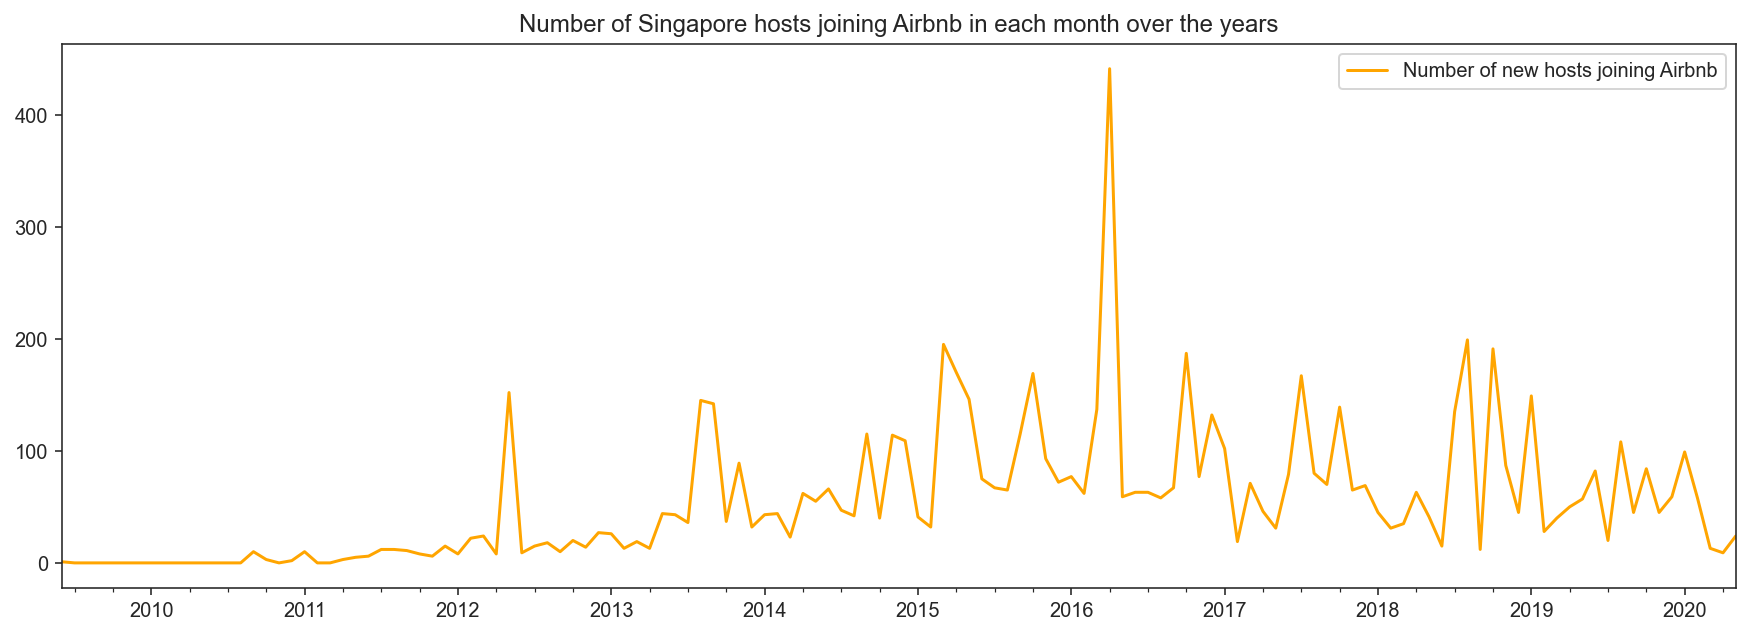

In [54]:
# Plot number of new listings hosted on Airbnb platform over the years

plt.figure(figsize=(15,5))
listings.set_index('host_since').resample('MS').size().plot(label='Number of new hosts joining Airbnb', color='orange')
plt.title('Number of Singapore hosts joining Airbnb in each month over the years')
plt.legend()
plt.xlim('2009-06-01', '2020-05-31') 
plt.xlabel('')
plt.ylabel('')
plt.show()

From the line plot above, the growth in the number of new listings has remained fairly constant since 2014, with a sharp spike in new listings in Apr 2016. This is despite the fact that the Singapore government has passed a law in May 2017 forbidding owners of private residential properties from renting out their property for less than 3 consecutive months, unless they have permission from the Urban Redevelopment Authority (URA) to do so. As for Housing Board flats, their rental periods have to be at least six months and they cannot be rented out to tourists. (https://singaporelegaladvice.com/law-articles/is-airbnb-illegal-singapore)

There is some noticeable seasonality in the new listings, with notable peaks in the middle and end of the year to take advantage of the increased demand during the holiday periods.  

### Numerical features

#### Distribution of listing price (target variable)

<AxesSubplot:xlabel='price'>

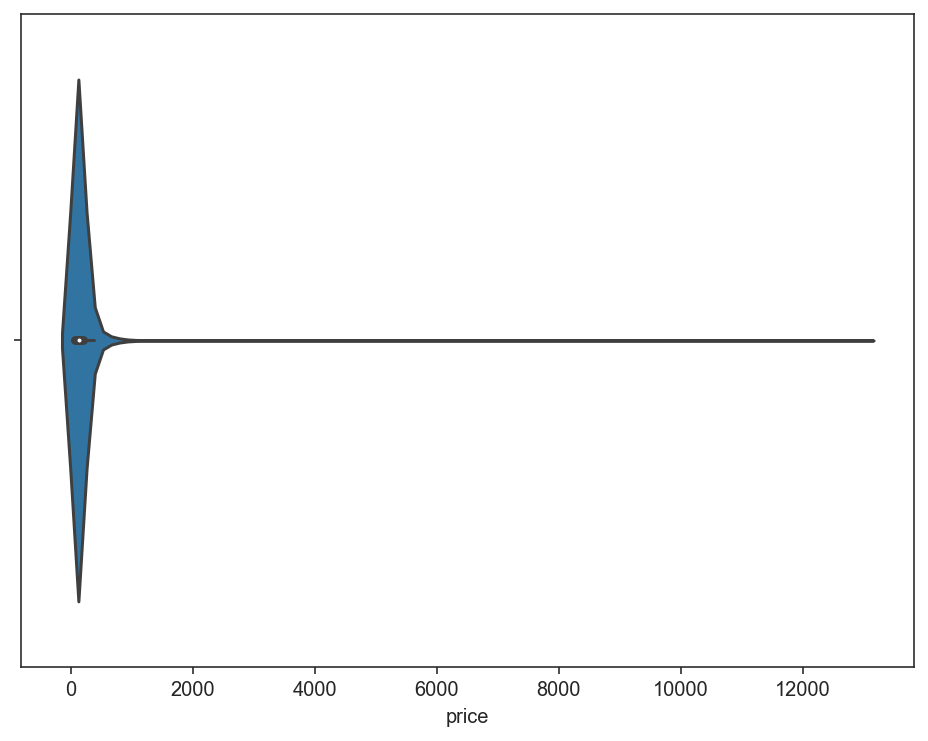

In [55]:
# Plot histogram of listing price
plt.figure(figsize=(8,6))
sns.violinplot(listings.price)

In [56]:
listings.price.describe()

count     7323.000000
mean       175.760481
std        483.395750
min         14.000000
25%         63.000000
50%        124.000000
75%        190.000000
max      13000.000000
Name: price, dtype: float64

The listing prices range from \\$14 to $13,000. The extreme high price outliers are due to limitation of the data which scrapped the advertised price rather than the actual price paid by the customers, as the advertised prices can be set to an arbitrary amount by the hosts and will be shown when calendar dates are not entered on the site.    

The price outliers would need to be dealt with as it will impact model performance. I will drop those data with extreme high price outliers as the listing price is likely to be erroneous and far from the actual price paid by customers.  

In [31]:
# Compute inter-quartile range and remove extreme outliers based on 1.5x IQR above 3rd quartile price 
q1_price = np.quantile(listings['price'],0.25, interpolation='midpoint')
q3_price = np.quantile(listings['price'],0.75, interpolation='midpoint')
outlier_price = q3_price + 1.5*(q3_price - q1_price)

listings = listings[listings['price'] < outlier_price]
listings.reset_index(drop=True, inplace=True)

In [32]:
listings.shape

(6973, 80)

In [59]:
# Summarise descriptive statistics for numerical features
listings.describe()

id       host_id     latitude    longitude  accommodates  \
count  6.973000e+03  6.973000e+03  6973.000000  6973.000000   6973.000000   
mean   2.677594e+07  1.046207e+08     1.314660   103.847371      3.103686   
std    1.218021e+07  9.537014e+07     0.031215     0.043525      2.290632   
min    4.909100e+04  2.366600e+04     1.245260   103.665470      1.000000   
25%    1.683075e+07  2.511686e+07     1.296260   103.837730      2.000000   
50%    2.878826e+07  6.640618e+07     1.311330   103.849890      2.000000   
75%    3.809214e+07  1.705613e+08     1.323180   103.865740      4.000000   
max    4.388012e+07  3.500839e+08     1.454590   103.971710     16.000000   

         bathrooms     bedrooms         beds        price  security_deposit  \
count  6973.000000  6973.000000  6973.000000  6973.000000       6973.000000   
mean      1.504948     1.256561     1.893159   129.732540        156.107414   
std       1.144757     0.773189     2.436438    80.202485        417.242708   
min       0.000000     0.000000     0.000000    14.000000          0.000000   
25%       1.000000     1.000000     1.000000    60.000000          0.000000   
50%       1.000000     1.000000     1.000000   119.000000          0.000000   
75%       2.000000     1.000000     2.000000   175.000000        200.000000   
max      21.000000    10.000000    58.000000   380.000000       6500.000000   

       cleaning_fee  guests_included  extra_people  minimum_nights  \
count   6973.000000      6973.000000   6973.000000     6973.000000   
mean      27.041015         1.811989     13.976624       21.084325   
std       37.843929         1.482665     19.293024       46.839576   
min        0.000000         1.000000      0.000000        1.000000   
25%        0.000000         1.000000      0.000000        2.000000   
50%       20.000000         1.000000     10.000000        4.000000   
75%       40.000000         2.000000     20.000000       18.000000   
max      900.000000        50.000000    400.000000     1000.000000   

       maximum_nights  availability_30  availability_60  availability_90  \
count     6973.000000      6973.000000      6973.000000      6973.000000   
mean       924.899469        15.650222        34.061810        52.915818   
std       1276.106789        13.504976        26.862045        40.165585   
min          1.000000         0.000000         0.000000         0.000000   
25%       1124.000000         0.000000         0.000000         0.000000   
50%       1125.000000        21.000000        51.000000        79.000000   
75%       1125.000000        29.000000        59.000000        89.000000   
max     100000.000000        30.000000        60.000000        90.000000   

       availability_365  number_of_reviews  number_of_reviews_ltm  \
count       6973.000000        6973.000000            6973.000000   
mean         193.833931          12.708160               3.828194   
std          159.259992          32.006165               9.320904   
min            0.000000           0.000000               0.000000   
25%            1.000000           0.000000               0.000000   
50%          181.000000           1.000000               0.000000   
75%          363.000000           8.000000               2.000000   
max          365.000000         370.000000             139.000000   

       calculated_host_listings_count  reviews_per_month  host_days_active  \
count                     6973.000000        6973.000000       6973.000000   
mean                        44.388642           0.472878       1490.197862   
std                         76.409848           1.115084        766.161573   
min                          1.000000           0.000000          8.000000   
25%                          2.000000           0.000000        872.000000   
50%                         10.000000           0.090000       1535.000000   
75%                         52.000000           0.430000       2009.000000   
max                        335.000000          28

#### Histogram Plots of Listing Price vs Numerical Features

In [33]:
# Create list with only numerical columns
col_numerical = [col for col in listings.columns if listings[col].dtype != np.object]
col_numerical = [i for i in col_numerical if i not in ('id', 'host_id', 'host_since', 'latitude','longitude','first_review', 'last_review')]

# Create list with only categorical columns
col_categorical = [col for col in listings.columns if listings[col].dtype == np.object]
col_categorical = [i for i in col_categorical if i not in ('summary', 'description', 'transit', 'neighbourhood_cleansed','property_type')]

In [34]:
# Create functions for distribution plots

# histogram subplots
def subplot_histograms(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        ax[i].hist(dataframe[column],bins=15)
        ax[i].set_title(f'{column} distribution',fontsize=14)
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
        ax[i].set_ylabel('frequency', fontsize=14)
        ax[i].axvline(dataframe[column].mean(), linestyle = '--', color = 'r', label ='mean')
        ax[i].axvline(dataframe[column].median(), linestyle = '--', color = 'b', label ='median')
        ax[i].legend()
    plt.tight_layout()
    
# scatterplot subplots
def subplot_scatter(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(12, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.regplot(y=dataframe.price, x=dataframe[column],ax=ax[i], \
                    line_kws = {'color':'grey'})
        ax[i].set_title(f'{column} vs price',fontsize=14)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
        ax[i].set_ylabel('price', fontsize=14)
    plt.tight_layout()
    
# violin subplots
def subplot_violin(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(15, nrows*4)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.violinplot(x = dataframe[column], y = dataframe.price, width = 0.3, ax = ax[i],orient='v')
        ax[i].set_title(f'Distribution of listing price by {column}',fontsize=14)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=12)
        ax[i].set_ylabel('price', fontsize=12)
    plt.tight_layout()

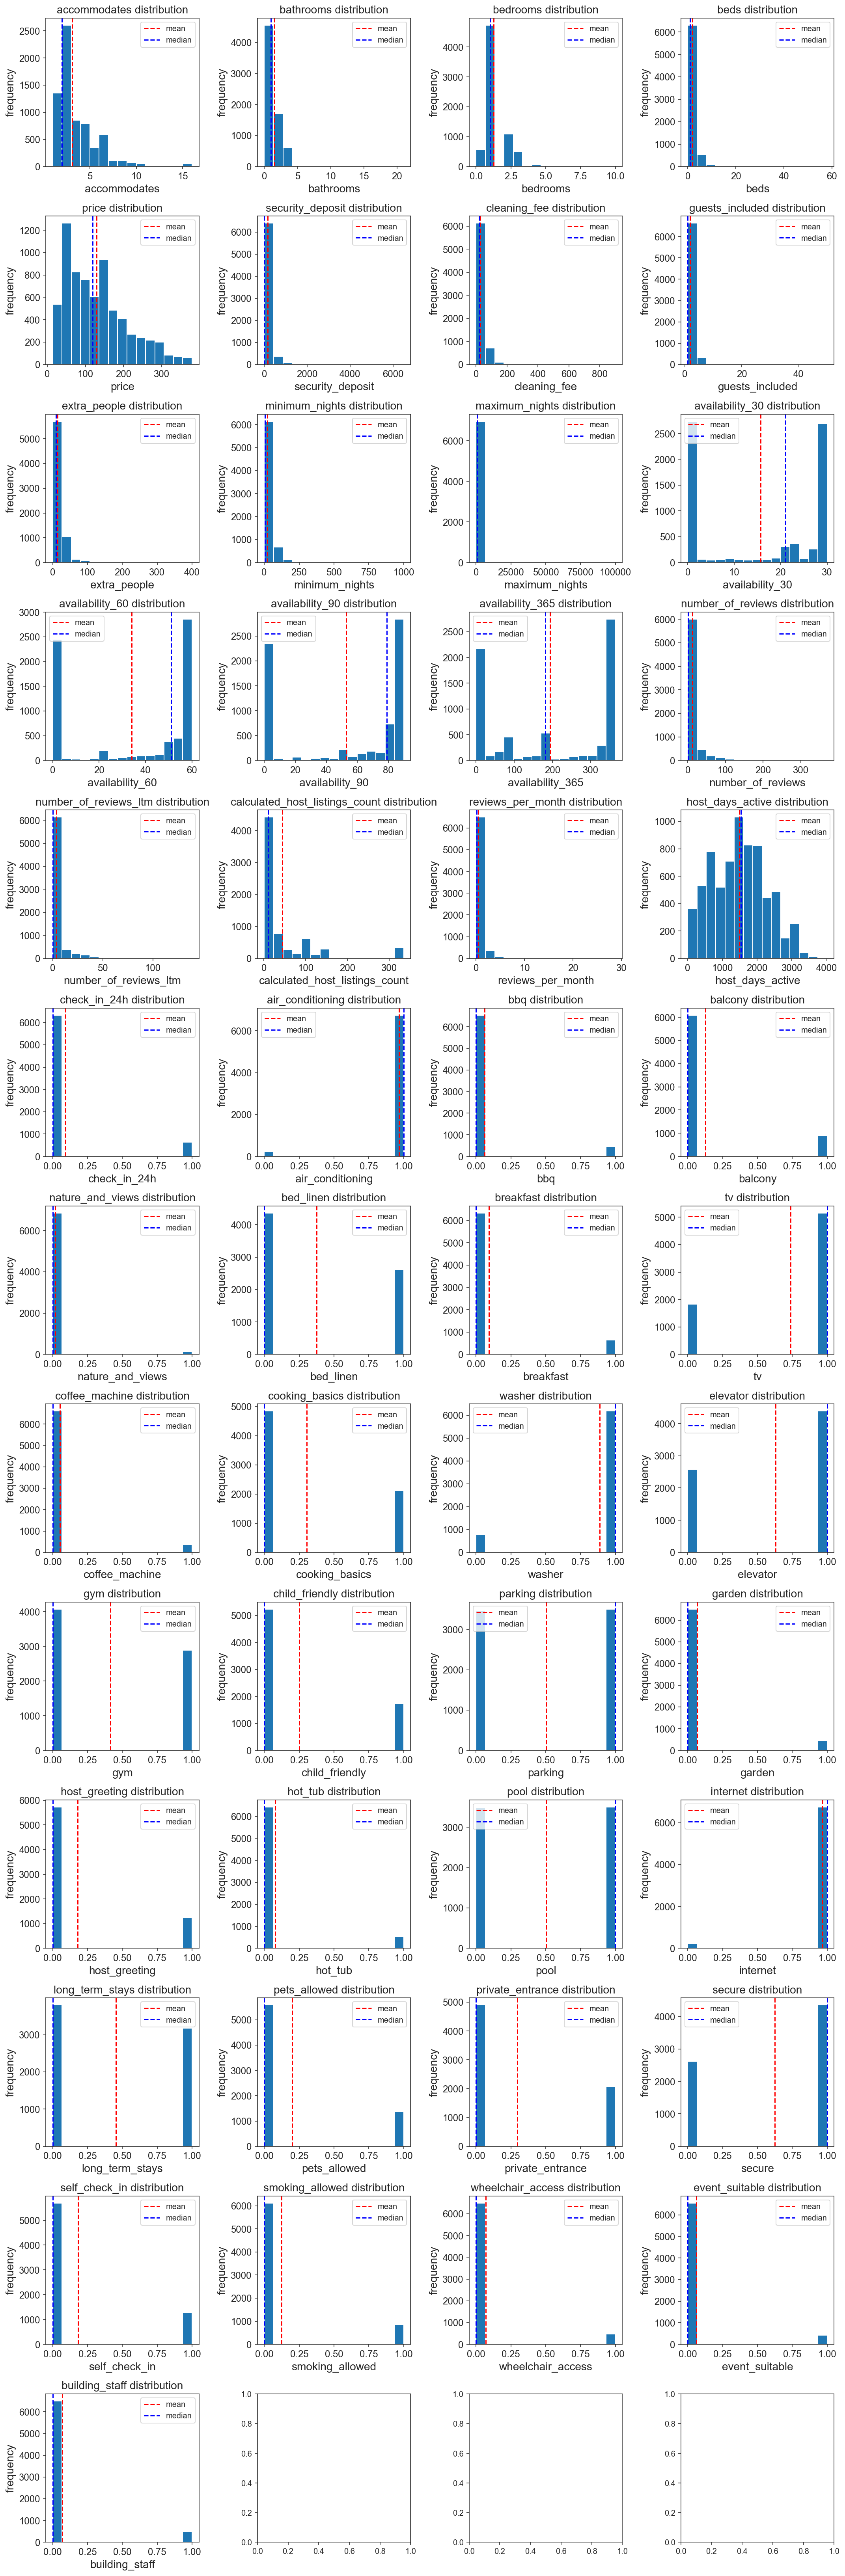

In [68]:
subplot_histograms(listings,col_numerical)

From the above histograms, we can observe that the target variable (listing price) and most of the continuous numerical features have a positively skewed distribution. They would be transformed to a logarithmic scale during the later pre-processing steps to normalize the distribution.

#### Number of people accommodated, bathrooms, bedrooms and beds

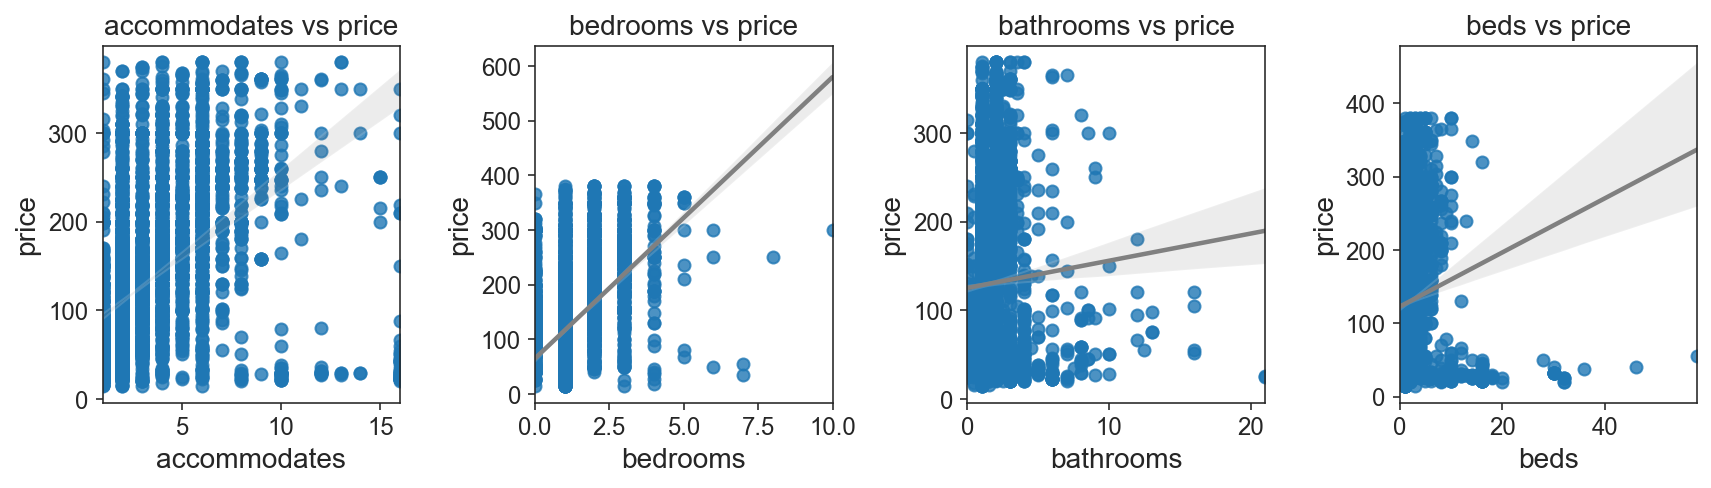

In [59]:
subplot_scatter(listings, ['accommodates', 'bedrooms', 'bathrooms', 'beds'])

In [72]:
listings[['beds','bathrooms','property_category']].groupby(by='property_category').max()

beds  bathrooms
property_category                 
apartment          32.0        8.0
condo              10.0        6.0
hostel             58.0       21.0
svc_apt_hotel       8.0       10.0

From the scatter plots above, we can observe that properties which can accommodate more people and have more bedrooms generally are listed at higher nightly prices as seen from the strong upward sloping regression line, which is intuitive given that an accommmodation which has a bigger size is likely to command a higher booking fee. 

There are some properties that have very high number of bathrooms and beds but with very low listing prices. Further examination reveals they actually correspond to hostel listings which have shared common toilets.

#### Security deposit, cleaning fee,  price per extra person and number of guests included

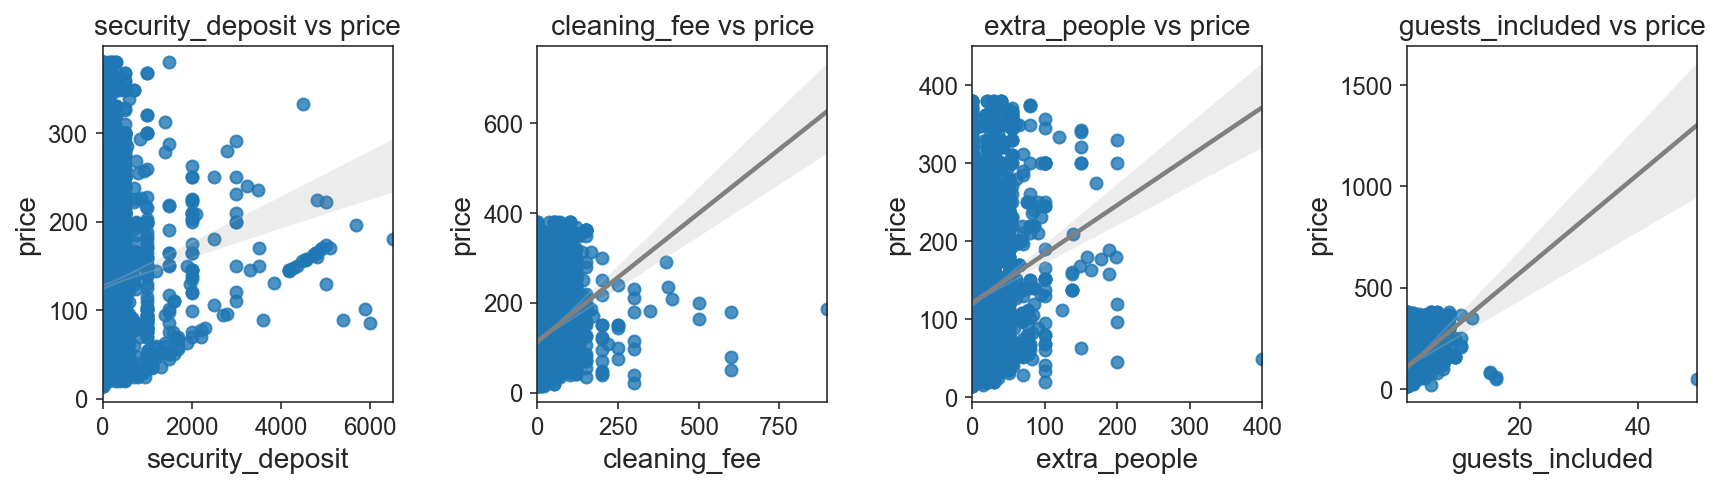

In [73]:
subplot_scatter(listings, ['security_deposit', 'cleaning_fee', 'extra_people', 'guests_included'])

From the scatter plots above, we can observe that properties which have a higher amount of security deposit, cleaning fee, extra person charge and number of guests included in the booking fee are generally listed at higher prices. 

The high amount of security deposit (in the thousands) and cleaning required for some of the properties are mainly listings which are rented out as an entire home to guests for long term stay (minimum of 3 months for condominium and 6 months for HDB). 

There are some listings which have a high number of guests included (>15) in the booking fee but are listed at very low prices. A website check on these listings reveal that these are actually hostels/ pod accommodations which have the data entered wrongly by the hosts, e.g. the listing with 50 guests included is likely to correspond to the extra person charge fee and the 16 guests included actually refers to a 16-bed hostel room but the price listed is based on per person rate rather than the whole dormitory room. Hence, I will modify these erroneous values to preserve the data.  

In [74]:
listings[listings['guests_included']>15]

id                                            summary  \
5134  37498999                                                NaN   
5669  40015115  99 hostel  is located in a heritage building n...   
5920  40904925  Nestled within the hustle and bustle of Chinat...   

                                            description  \
5134                                                NaN   
5669  99 hostel  is located in a heritage building n...   
5920  Nestled within the hustle and bustle of Chinat...   

                                                transit    host_id host_since  \
5134                                                NaN   11804730 2014-01-31   
5669                                                NaN  307061241 2019-11-04   
5920  It is 230 m to Chinatown MRT Station and 140 m...   50960671 2015-12-10   

     host_response_time host_response_rate host_acceptance_rate  \
5134            unknown            unknown                0-49%   
5669            unknown            unknown              unknown   
5920       within a day              0-49%               70-89%   

     host_is_superhost host_identity_verified neighbourhood_cleansed  \
5134                 f                      f                Kallang   
5669                 f                      f        Singapore River   
5920                 f                      f                 Outram   

     neighbourhood_group_cleansed  latitude  longitude property_type  \
5134               Central Region   1.31306  103.87086         House   
5669               Central Region   1.28747  103.84778         House   
5920               Central Region   1.28312  103.84489        Hostel   

        room_type  accommodates  bathrooms  bedrooms  beds  price  \
5134  Shared room             1        1.0       1.0   1.0   48.0   
5669  Shared room             1        3.0       1.0  10.0   60.0   
5920  Shared room             4        2.5       1.0   4.0   50.0   

      security_deposit  cleaning_fee  guests_included  extra_people  \
5134             150.0          18.0               16          48.0   
5669             136.0           7.0               16          45.0   
5920               0.0           0.0               50          50.0   

      minimum_nights  maximum_nights  availability_30  availability_60  \
5134               2             180               30               60   
5669               1              28               29               59   
5920               1             365               21               51   

      availability_90  availability_365  number_of_reviews  \
5134               90               365                  0   
5669               89               180                  0   
5920               81               169                  2   

      number_of_reviews_ltm first_review last_review review_scores_rating  \
5134                      0          NaT         NaT           no reviews   
5669                      0          NaT         NaT           no reviews   
5920                      2   2020-01-20  2020-01-20            80-89/100   

     review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
5134             no reviews                no reviews            no reviews   
5669             no reviews                no reviews            no reviews   
5920                  10/10                      9/10                 10/10   

     review_scores_communication review_scores_location review_scores_value  \
5134                  no reviews             no reviews          no reviews   
5669                  no reviews             no reviews          no reviews   
5920                        9/10                  10/10              0-8/10   

     instant_bookable cancellation_policy  calculated_host_listings_count  \
5134                t            flexible                               2   
5669                f            flexible                               1   
5920                t            moderate   

In [35]:
# Correct erroneous outliers by replacing with '1' value
listings['guests_included'][5134] = 1
listings['guests_included'][5669] = 1
listings['guests_included'][5920] = 1

### Categorical features

#### Neighbourhood

In [63]:
# Check number of unique neighbourhoods
listings['neighbourhood_cleansed'].nunique()

41

In [36]:
# Extract neighbourhood features in geojson file to dataframe
import json

map_data = json.load(open('../data/neighbourhoods.geojson'))
neighbourhoods_data = map_data['features']

neighbourhoods_map_df = pd.DataFrame()

for data in neighbourhoods_data:
    neighbourhood_name = data['properties']['neighbourhood']
    coordinates = data['geometry']['coordinates']
    neighbourhoods_map_df = neighbourhoods_map_df.append({'neighbourhood_cleansed': neighbourhood_name}, ignore_index=True)
neighbourhoods_map_df.head()

neighbourhood_cleansed
0              Pasir Ris
1                Seletar
2           Sungei Kadut
3                Orchard
4                Simpang

In [37]:
# Create a dataframe of listing counts and median price grouped by neighbourhood
neighbourhood_df = pd.DataFrame(listings.groupby('neighbourhood_cleansed').size())
neighbourhood_df.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_df['median_price'] = listings.groupby('neighbourhood_cleansed').price.median().values
neighbourhood_df.head()

number_of_listings  median_price
neighbourhood_cleansed                                  
Ang Mo Kio                              45          60.0
Bedok                                  313          99.0
Bishan                                  56          79.0
Bukit Batok                             53          79.0
Bukit Merah                            346         112.5

In [38]:
# Join the dataframe to neighbourhood map dataframe (extracted from geojson file) and fill null values with 0
neighbourhood_df_merged = neighbourhoods_map_df.set_index('neighbourhood_cleansed').join(neighbourhood_df)
neighbourhood_df_merged = neighbourhood_df_merged.reset_index()
neighbourhood_df_merged = neighbourhood_df_merged.rename(columns={'neighbourhood_cleansed': 'neighbourhood'})
neighbourhood_df_merged.fillna(0, inplace=True)
neighbourhood_df_merged.sort_values(by='median_price',ascending=False).head()

neighbourhood  number_of_listings  median_price
9            Pioneer                 1.0         305.0
2       Sungei Kadut                 1.0         291.0
18  Southern Islands                10.0         263.5
22     Downtown Core               448.0         159.0
32           Tanglin               115.0         159.0

In [44]:
#!pip install -U kaleido

In [45]:
#!conda install -c plotly plotly-orca==1.2.1 psutil requests

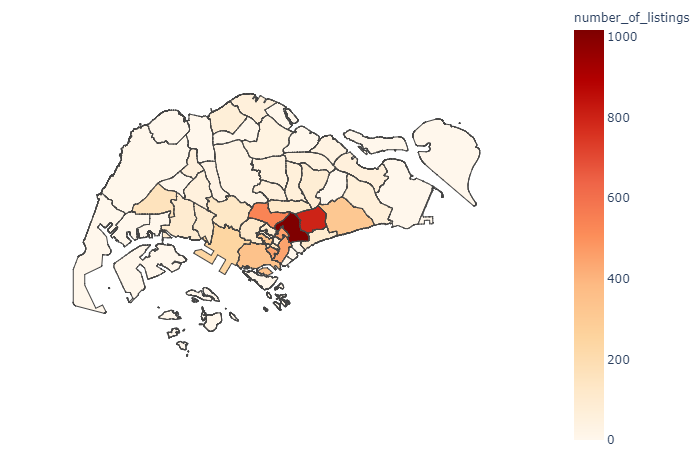

In [48]:
# Plot the number of listings in each neighbourhood
# !pip install plotly

import plotly.express as px

fig = px.choropleth(neighbourhood_df_merged, geojson=map_data, color="number_of_listings",color_continuous_scale='OrRd',
                    locations="neighbourhood", featureidkey="properties.neighbourhood",
                    projection="mercator"
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("png")
#fig.write_html("../html/num_listings_neighbourhood.html")

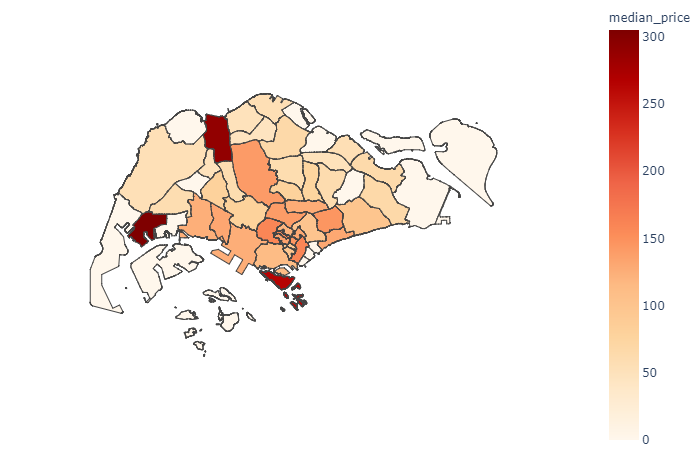

In [49]:
# Plot the median listing price in each neighbourhood

fig = px.choropleth(neighbourhood_df_merged, geojson=map_data, color="median_price",color_continuous_scale='OrRd',
                    locations="neighbourhood", featureidkey="properties.neighbourhood",
                    projection="mercator"
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("png")
#fig.write_html("../html/median_price_neighbourhood.html")

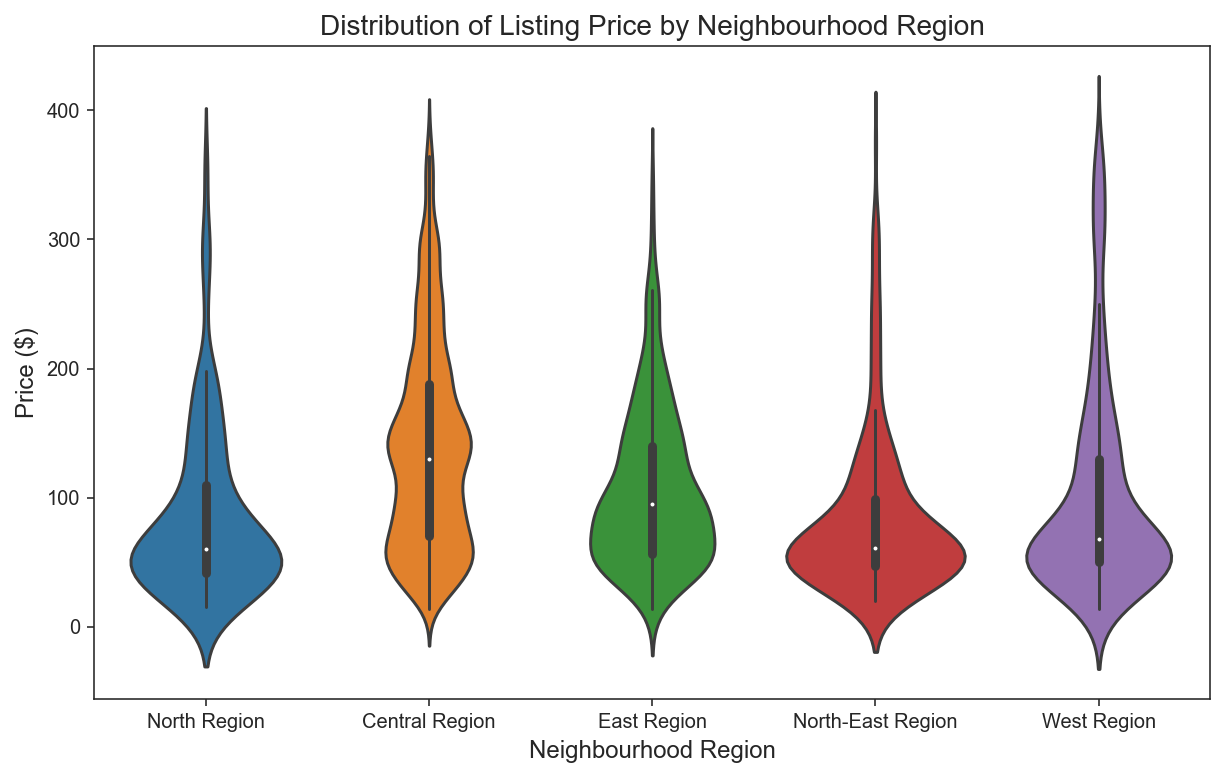

In [86]:
# Plot violin plots of listing price distribution by neighbourhood region
plt.figure(figsize=(10,6))
sns.violinplot(x = "neighbourhood_group_cleansed", y = "price", data = listings)

plt.title('Distribution of Listing Price by Neighbourhood Region', fontsize=14)
plt.xlabel('Neighbourhood Region', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.show()

From the geospatial choropleth maps above, the most number of listings are clustered in the Central region, with Kallang and Geylang neighbourhoods having the most number of listings of 1017 and 797 respectively.

In terms of listing prices, the central neighbourhoods have the most expensive listings compared to other neighbourhoods, with Southern Islands and Tanglin having the most expensive listings with median price of \\$263 and $159 respectively, which is not surprising given their location accessibility to the city and tourist attractions around the area. The listings in the northern and western outskirts neighbourhood such as Sungei Kadut and Pioneer neighbourhoods are also listed at high prices but it should be noted there is only one listing (higher priced condominium type) in those neighbourhoods.

From the violin plot of listing price distribution in the central region, it is bimodal with the 2 peaks corresponding to the city neighbourhoods (e.g. Orchard/ Tanglin/ Novena) and city fringe neighbourhoods (e.g. Bishan/ Bukit Timah). 

As there are a large number of different levels (42 of them) in the neighbourhood column with majority having low frequency counts, and there is already a grouped neighbourhood region feature which accounts for location, this feature will be dropped subsequently. A new distance-based feature will be created under feature engineering to account for the proximity to city centre where listing prices are generally higher if they are nearer to the city centre. 

#### Property and room types

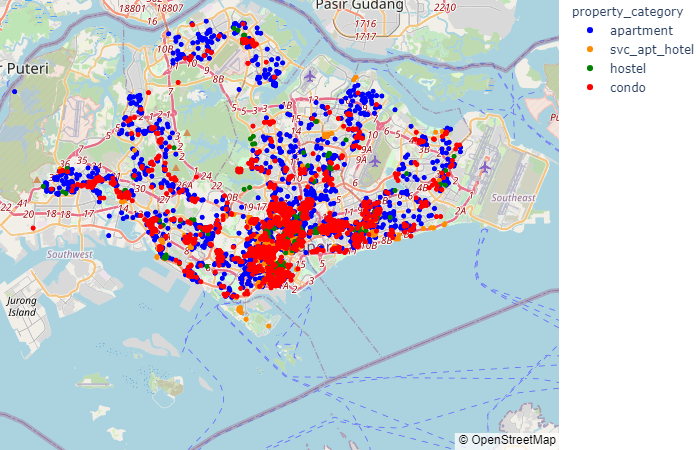

In [50]:
# Plot geospatial scatter plots of listings by property type 

fig = px.scatter_mapbox(listings, lat="latitude", lon="longitude", hover_name="host_id", 
                        hover_data=["property_category", "room_type"], zoom=10, height=400,color="property_category", 
                        color_discrete_sequence=px.colors.qualitative.G10,
                        color_discrete_map={
                            "apartment": "blue","condo": "red","svc_apt_hotel": "darkorange", "hostel": "green",}, 
                        size_max=15)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("png")
#fig.write_html("../html/property_type_geospatial_scatterplot.html")

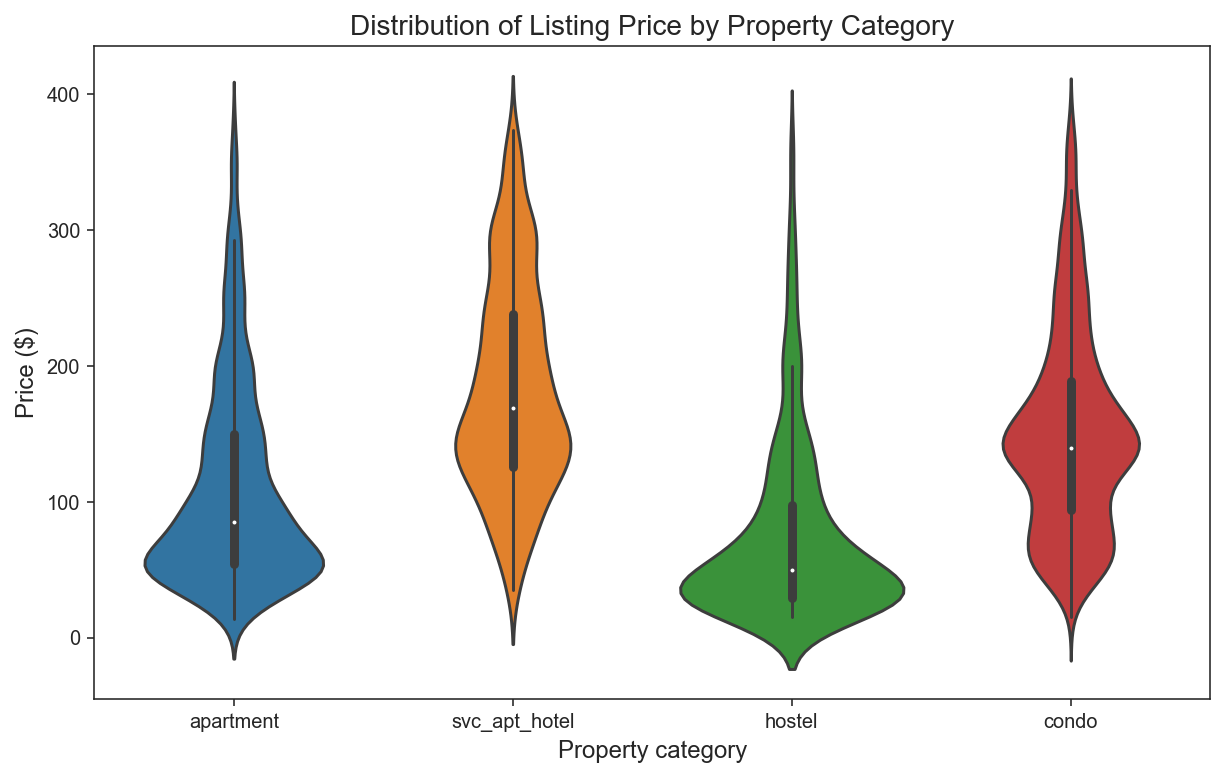

In [89]:
# Violin plots of listing price distribution by property category
plt.figure(figsize=(10,6))
sns.violinplot(x = "property_category", y = "price", data = listings)

plt.title('Distribution of Listing Price by Property Category', fontsize=14)
plt.xlabel('Property category', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.show()

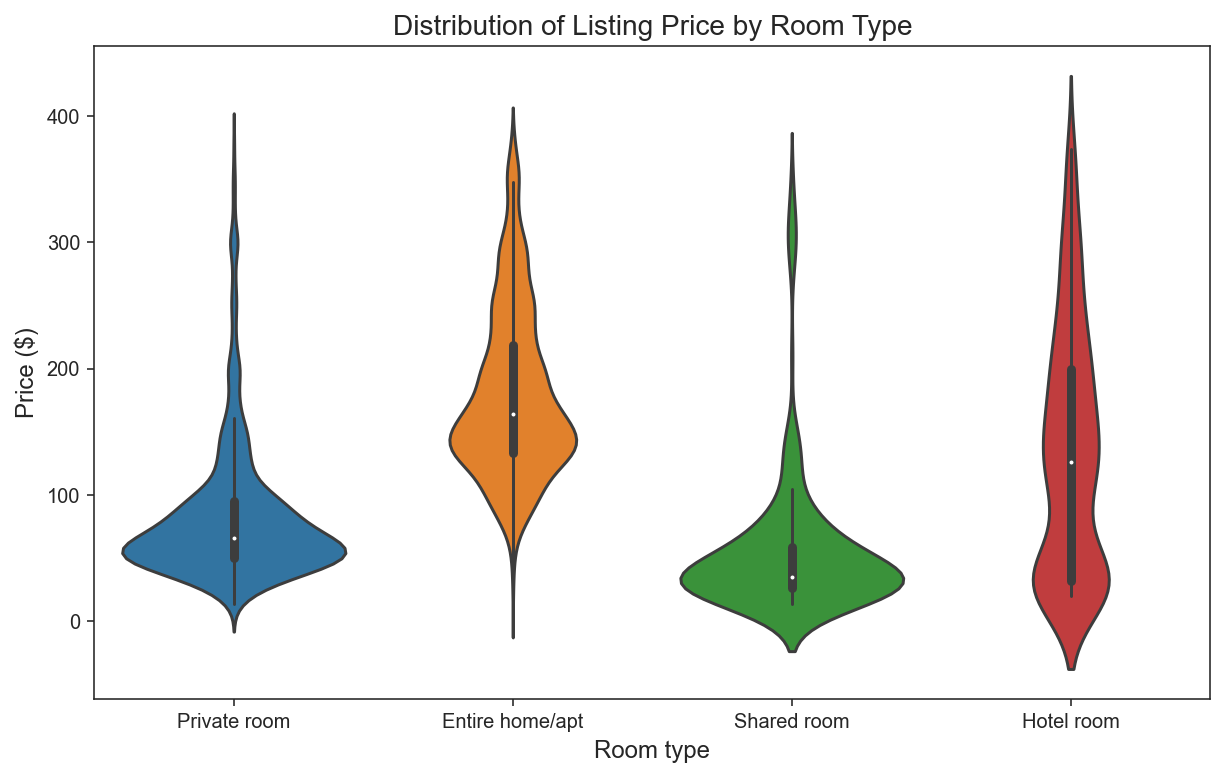

In [90]:
# Violin plots of listing price distribution by room type
plt.figure(figsize=(10,6))
sns.violinplot(x = "room_type", y = "price", data = listings)

plt.title('Distribution of Listing Price by Room Type', fontsize=14)
plt.xlabel('Room type', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.show()

In [94]:
listings.groupby(by='property_category').price.median()

property_category
apartment         85.0
condo            140.0
hostel            50.0
svc_apt_hotel    169.5
Name: price, dtype: float64

In [93]:
listings.groupby(by='room_type').price.median()

room_type
Entire home/apt    164.0
Hotel room         126.5
Private room        66.0
Shared room         35.0
Name: price, dtype: float64

From the geospatial scatter plot above, about 80% of the listings are either apartments or condominiums with the apartments quite evenly distributed across different parts of Singapore. The higher-end serviced apartments and condominiums are mainly clustered at the more expensive city central area.  

Based on the violin plots above, we can observe that property category and room type influences the listing price, with the serviced apartment and condominium property types listed at higher prices (median price of \\$169 and $140 respectively) compared to apartment and hostel property categories.

Comparatively, the price will be higher if the property is rented out entirely (median price of \\$164) compared to private or shared rooms. The lowest listing prices correspond to hostel properties with shared rooms due to their limited facilities. 

#### Review scores

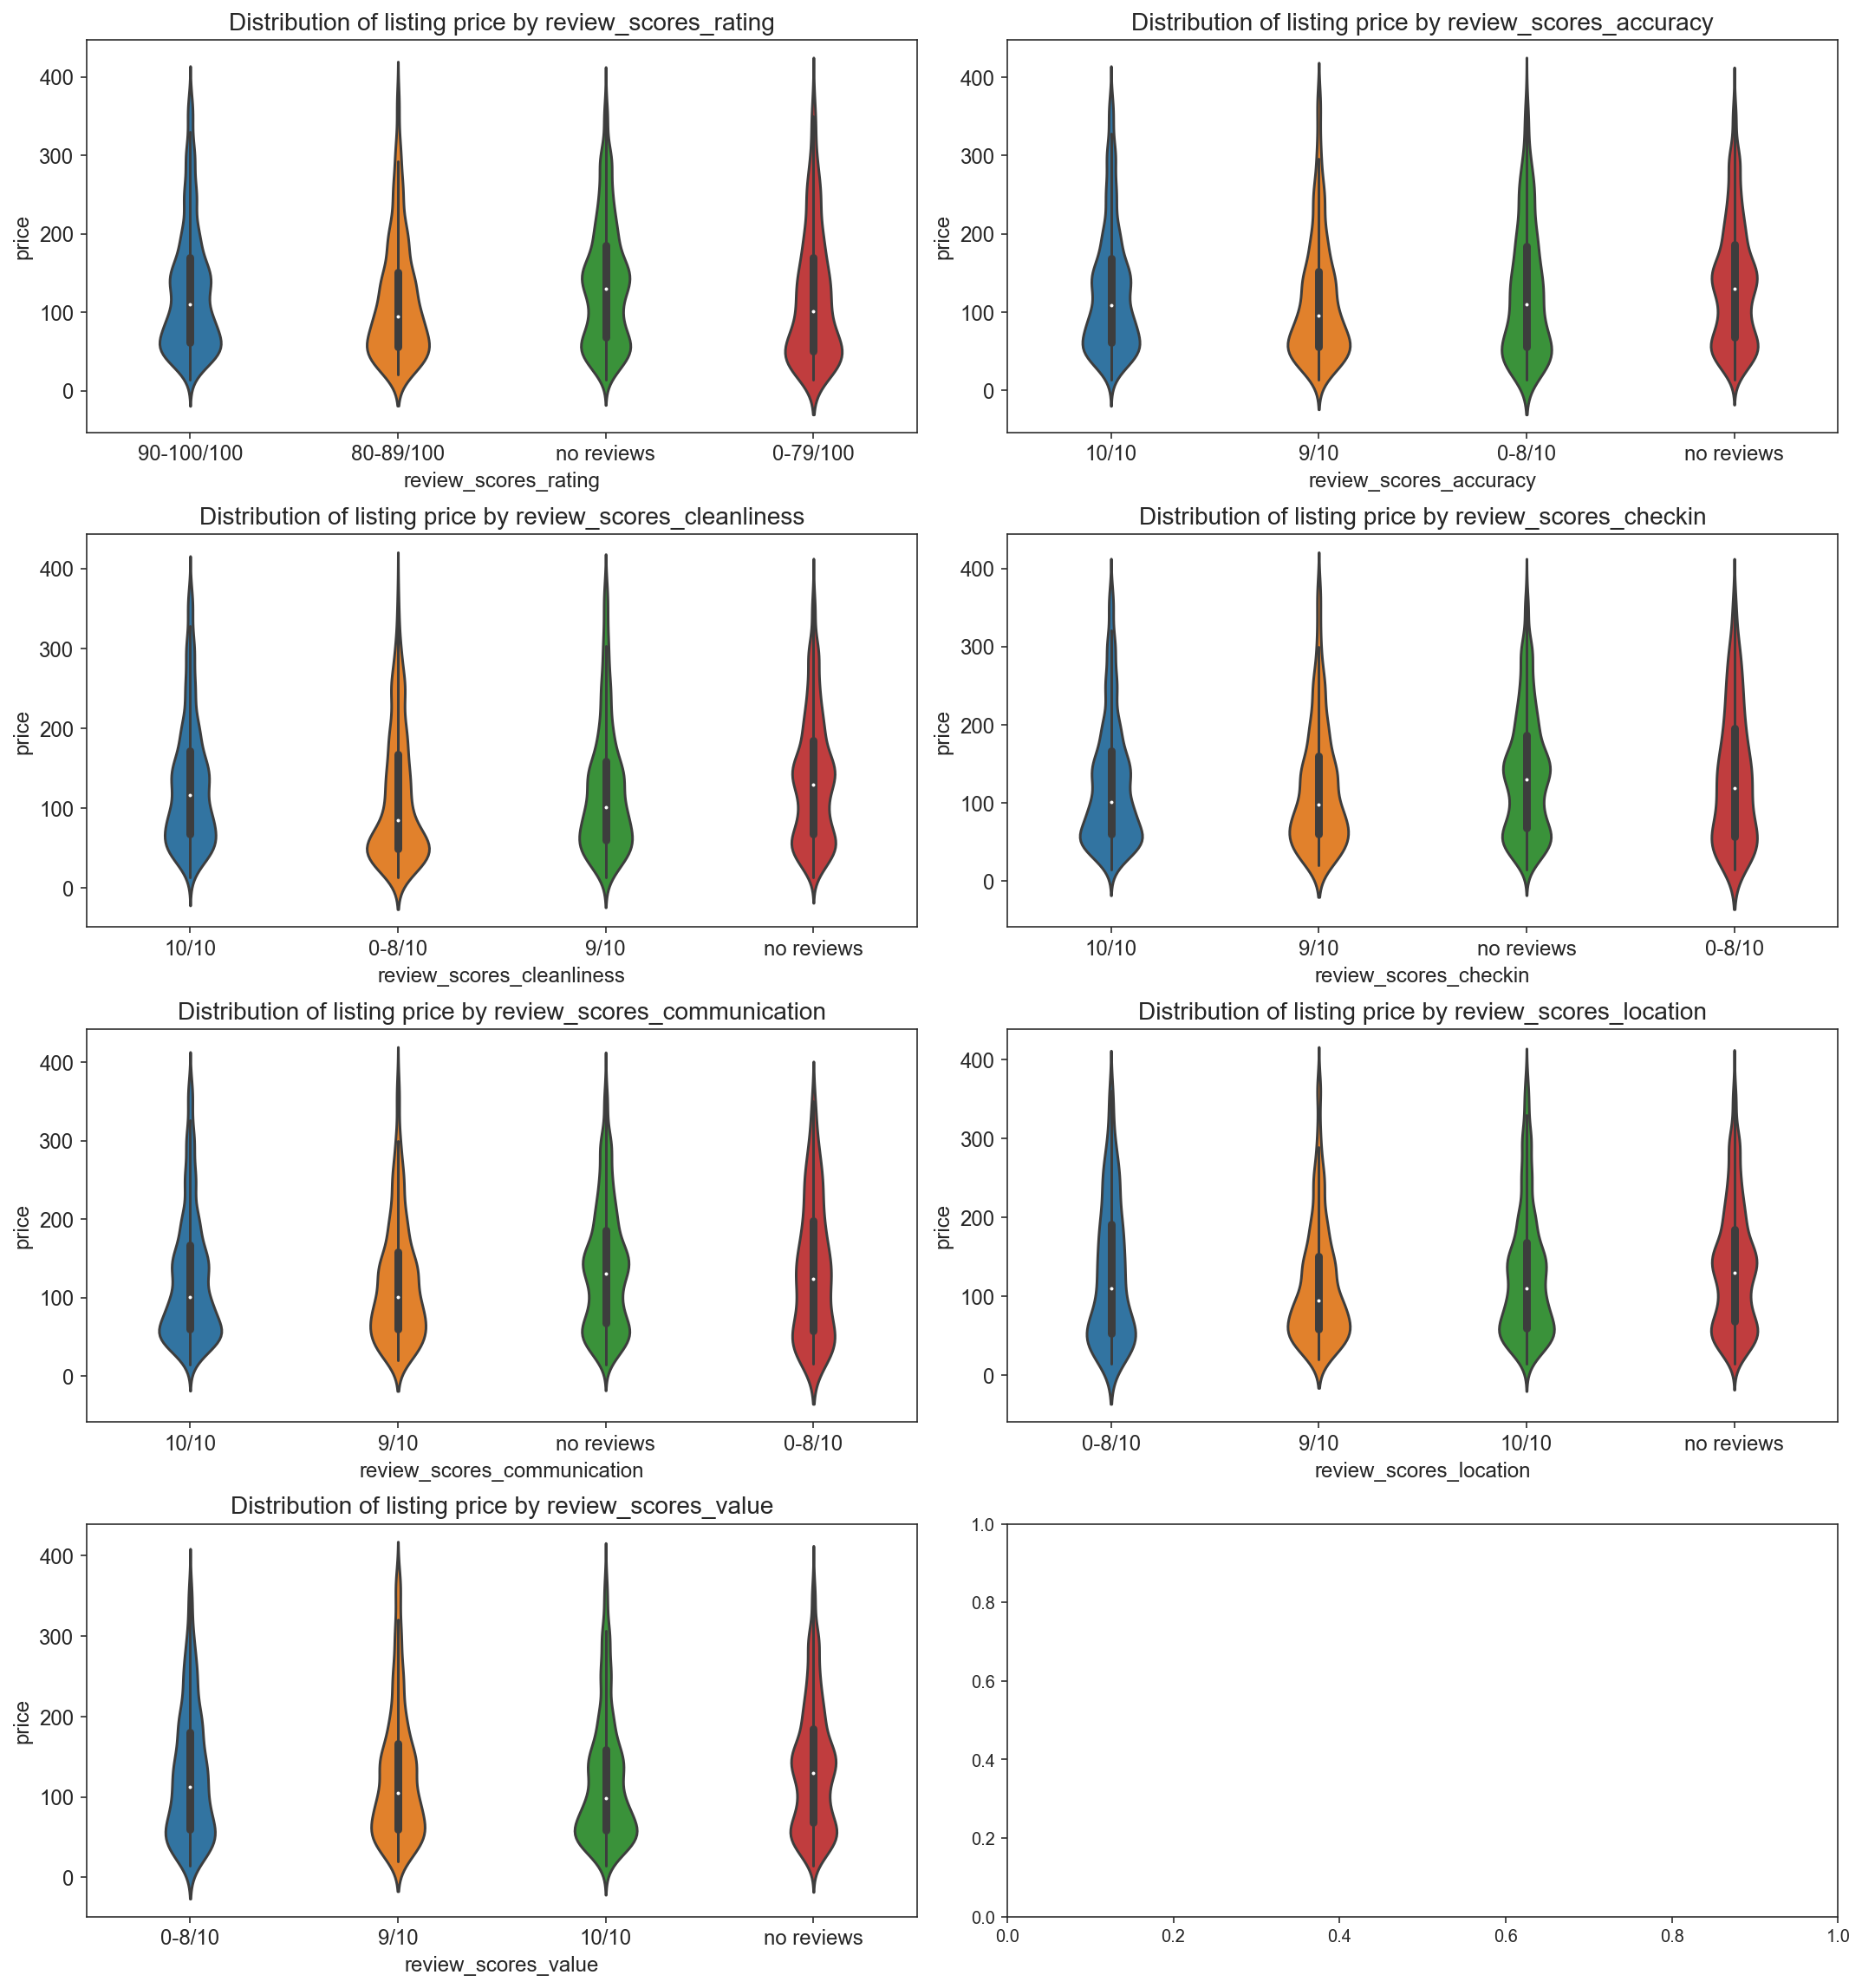

In [96]:
subplot_violin(listings, ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin','review_scores_communication','review_scores_location',
                          'review_scores_value'])

In [97]:
listings.groupby(by='review_scores_rating').price.median()

review_scores_rating
0-79/100      101.0
80-89/100      95.0
90-100/100    110.0
no reviews    130.0
Name: price, dtype: float64

As mentioned earlier, majority of the reviews are of high scores above 9/10 for listings that have received reviews. This could be due to herding behaviour or under-reporting of negative reviews where reviewers fear retaliatory negative reviews since Airbnb allows both guests and hosts to leave online reviews for each other after every completed trip.   

The review scores only have a marginal impact on listing price based on the violin plots above. Sentiment analysis scores on the review text for better understanding on the reviews will be explored under the feature engineering section to check whether it is a good predictor for listing price. 

#### Super hosts and host verification

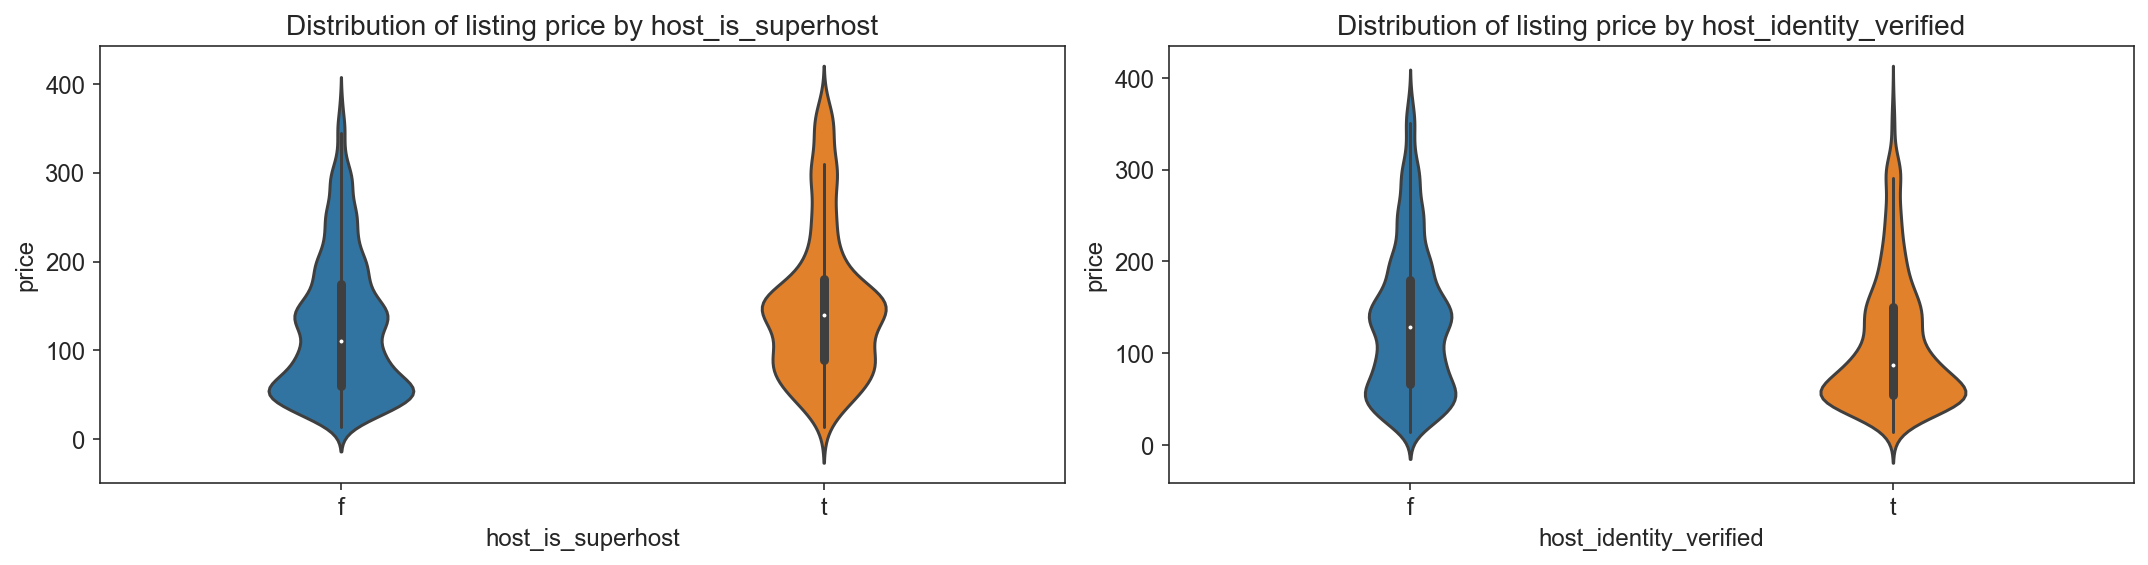

In [98]:
subplot_violin(listings, ['host_is_superhost','host_identity_verified'])

About 16% of the hosts are superhosts. To qualify for superhost status, the four criteria are:

- Host a minimum of 10 stays in a year
- Respond to guests quickly and maintain a 90% response rate or higher
- Have at least 80% 5-star reviews or or maintain a 4.8 overall rating
- Honour confirmed reservations (meaning hosts should rarely cancel) 

From the violin plots above, superhost are charging more with a median listing price of \\$140 per night compared to non-superhost with a median price of \\$110. This could an incentive for been a superhost as the reputation could lead to more bookings and revenue.  

With regards to host verification, only about 22% of the hosts have their identity verified. Surprisingly, despite the fact that one might expect the additional trust commanded by verified hosts to result in higher nightly prices, the price listings by verified hosts are actually much lower with median of \\$87 compared to unverified hosts with a median of $129 seen on the above violin plots.   

In [158]:
listings.groupby(by='host_is_superhost').price.median()

host_is_superhost
0    110.0
1    140.0
Name: price, dtype: float64

In [159]:
listings['host_is_superhost'].value_counts()

0    5866
1    1107
Name: host_is_superhost, dtype: int64

#### Amenities

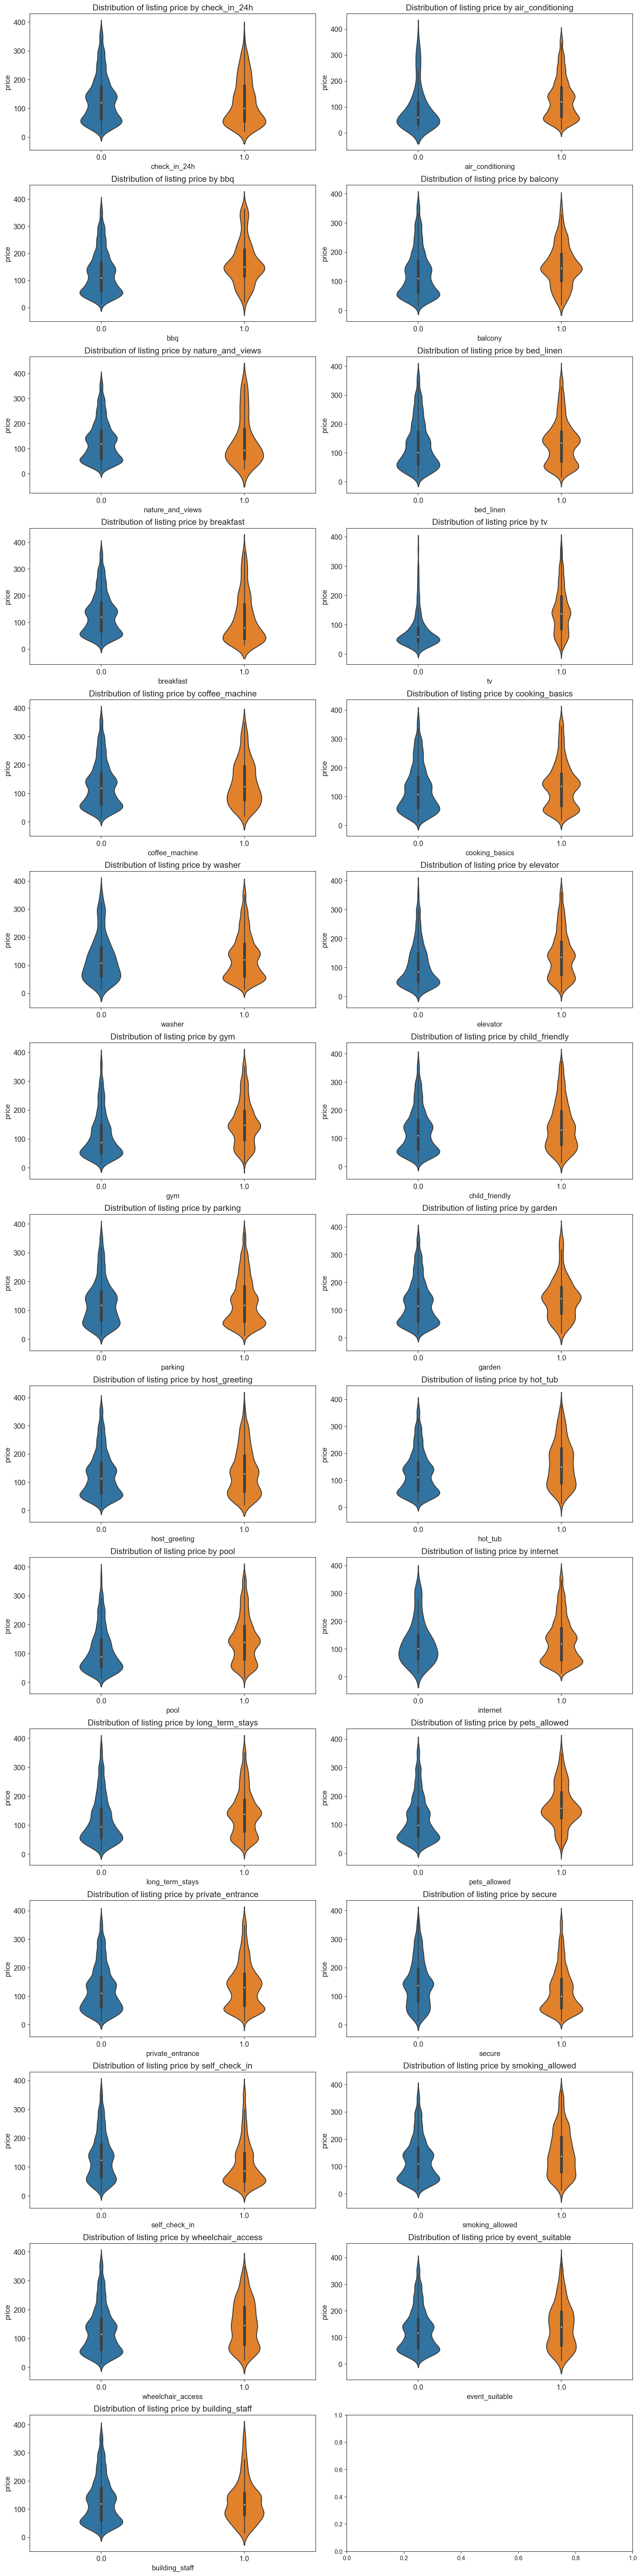

In [101]:
subplot_violin(listings, ['check_in_24h', 'air_conditioning', 'bbq', 'balcony',
       'nature_and_views', 'bed_linen', 'breakfast', 'tv', 'coffee_machine',
       'cooking_basics', 'washer', 'elevator', 'gym', 'child_friendly',
       'parking', 'garden', 'host_greeting', 'hot_tub', 'pool', 'internet',
       'long_term_stays', 'pets_allowed', 'private_entrance', 'secure',
       'self_check_in', 'smoking_allowed', 'wheelchair_access',
       'event_suitable', 'building_staff'])

In [87]:
listings.groupby(by='pets_allowed').price.median()

pets_allowed
0.0     99.0
1.0    158.0
Name: price, dtype: float64

In [80]:
listings['pool'].value_counts()

1.0    3499
0.0    3474
Name: pool, dtype: int64

We know the amenities provided by the hosts will influence the listing price. Based on the violin plots, all the different amenities above, with the exception of breakfast, secure box and self check-in actually results in a higher median listing price. Of note, the price differential is the highest for availability of TV amenity, with the median price more than 2x higher for 74% of the listings with TV (median price of \\$138), compared to 26% of the listings without TV (median price of \\$59).   

There is no significant price difference between properties which have parking facilities and building staff, and those without. 

## Feature Engineering

### Listing description text length

From personal experience, a customer would want to know as much information as possible about the listings before deciding on a place to stay. Highlighting characteristics, accessibility and location benefits of their listings could perhaps benefit hosts and how much they can ask for their listing. Hence, I will add in the text lengths of the listing `description` and `transit` description columns to examine this aspect.    

In [105]:
# Create new features for the text length in description and transit columns

listings[['description']] = listings[['description']].astype(str)
listings['description_text_length'] = [len(x) for x in listings['description'].str.split(' ')]
# 'nan' string is represented as 1. Replace with 0. 
listings.description_text_length.replace(1, 0, inplace=True)

listings[['transit']] = listings[['transit']].astype(str)
listings['transit_text_length'] = [len(x) for x in listings['transit'].str.split(' ')]
listings.transit_text_length.replace(1, 0, inplace=True)

In [106]:
listings.head(2)

id                                            summary  \
0  49091                                                NaN   
1  50646  Fully furnished bedroom with a nice view on th...   

                                         description  \
0  This is Room No. 2.(available after Jan 15 201...   
1  Fully furnished bedroom with a nice view on th...   

                                             transit  host_id host_since  \
0                                                nan   266763 2010-10-20   
1  Less than 400m from the apartment is the main ...   227796 2010-09-08   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour            95-100%              unknown   
1            unknown            unknown              unknown   

  host_is_superhost host_identity_verified neighbourhood_cleansed  \
0                 f                      f              Woodlands   
1                 f                      f            Bukit Timah   

  neighbourhood_group_cleansed  latitude  longitude property_type  \
0                 North Region   1.44255  103.79580     Apartment   
1               Central Region   1.33235  103.78521     Apartment   

      room_type  accommodates  bathrooms  bedrooms  beds  price  \
0  Private room             1        1.0       1.0   1.0   84.0   
1  Private room             2        1.0       1.0   1.0   80.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0               0.0           0.0                1          14.0   
1               0.0           0.0                2          20.0   

   minimum_nights  maximum_nights  availability_30  availability_60  \
0             180             360               30               60   
1              90             730               30               60   

   availability_90  availability_365  number_of_reviews  \
0               90               365                  1   
1               90               365                 18   

   number_of_reviews_ltm first_review last_review review_scores_rating  \
0                      0   2013-10-21  2013-10-21           90-100/100   
1                      0   2014-04-18  2014-12-26           90-100/100   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                  10/10                     10/10                 10/10   
1                   9/10                     10/10                 10/10   

  review_scores_communication review_scores_location review_scores_value  \
0                       10/10                 0-8/10              0-8/10   
1                       10/10                   9/10                9/10   

  instant_bookable cancellation_policy  calculated_host_listings_count  \
0                f            flexible                               2   
1                f            moderate                               1   

   reviews_per_month  host_days_active days_since_first_review  \
0               0.01            3533.0                >4 years   
1               0.24            3575.0                >4 years   

  days_since_last_review  check_in_24h  air_conditioning  bbq  balcony  \
0               >2 years           0.0               1.0  0.0      0.0   
1               >2 years           0.0               1.0  0.0      0.0   

   nature_and_views  bed_linen  breakfast   tv  coffee_machine  \
0               0.0        0.0        0.0  1.0             0.0   
1               0.0        0.0        0.0  1.0             0.0   

   cooking_basics  washer  elevator  gym  child_friendly  parking  garden  \
0             0.0     1.0       1.0  0.0             0.0      0.0     0.0   
1             0.0     1.0       1.0  1.0             1.0      0.0     0.0   

   host_greeting  hot_tub  pool  internet  long_term_stays  pets_allowed  \
0            0.0      0.0   0.0       1.0              0.0           1.0   
1            0.0      0.0   1.0       1.0              0.0           0.0   

   private_entrance  sec

### Distance to nearest MRT station

Walkability to MRT stations is also an important consideration for customers in choosing an accommodation to stay, evident in property transactions. Hence it could be a useful predictor for the Airbnb listing price. 

I will be extracting the addresses of the different MRT station exit locations from the MRT stations location shape file data, then calling the *OneMap API* to search and return the latitudes and longitudes of those locations, and calculating the distance from each listing address to its nearest MRT station based on geodesic distances.        

In [107]:
#!pip install pyshp

In [108]:
import geopy.distance

# Create function to convert shapefile to csv. 

def read_shapefile(shp_path):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column holding
    the geometry information. This uses the pyshp package
    """
    import shapefile

    myshp = open(shp_path, "rb")
    # read file, parse out the records and shapes
    sf = shapefile.Reader(shp_path)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    # write into a dataframe
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)

    return df

In [110]:
# Read in MRT station location shape file data. Downloaded from data.gov.sg
mrt_latlong_df = read_shapefile("../assets/TrainStation_Jan2020/MRTLRTStnPtt.shp")

station_address_list = mrt_latlong_df["STN_NAME"].unique().tolist()
len(station_address_list)

166

In [111]:
## Geo-coding using OneMap API. https://docs.onemap.sg/#onemap-rest-apis
%%time
import requests

station_search_results = []
querystring = {}

for x in station_address_list:
    url = "https://developers.onemap.sg/commonapi/search"
    

    querystring.update({"searchVal":x,"returnGeom":"Y","getAddrDetails":"Y","pageNum":"1"})
    #print (querystring['searchVal'])
    
    payload = "------WebKitFormBoundary7MA4YWxkTrZu0gW\r\nContent-Disposition: form-data; name=\"searchVal\"\r\n\r\n\r\n------WebKitFormBoundary7MA4YWxkTrZu0gW\r\nContent-Disposition: form-data; name=\"returnGeom {Y/N}\"\r\n\r\n\r\n------WebKitFormBoundary7MA4YWxkTrZu0gW\r\nContent-Disposition: form-data; name=\"getAddrDetails {Y/N}\"\r\n\r\n\r\n------WebKitFormBoundary7MA4YWxkTrZu0gW\r\nContent-Disposition: form-data; name=\"pageNum\"\r\n\r\n\r\n------WebKitFormBoundary7MA4YWxkTrZu0gW--"
    headers = {
    'content-type': "multipart/form-data; boundary=----WebKitFormBoundary7MA4YWxkTrZu0gW",
    'Cache-Control': "no-cache",
    'Postman-Token': "5f4af03e-410e-4b28-93bc-05006b4de49a"
    }

    response = requests.request("GET", url, data=payload, headers=headers, params=querystring)
    

    station_search_results.append(response.json())

#print(response.text)
print('Search Done.')

Search Done.
Wall time: 18 s


In [112]:
station_latlong_df = pd.DataFrame()
for entry in range(len(station_search_results)):
    temp_df = pd.DataFrame.from_dict(station_search_results[entry]['results'])
    station_latlong_df = station_latlong_df.append(temp_df)

In [113]:
station_latlong_df.head(1)

SEARCHVAL BLK_NO ROAD_NAME                  BUILDING  \
0  EUNOS MRT STATION EXIT A              NIL  EUNOS MRT STATION EXIT A   

                    ADDRESS POSTAL           X            Y     LATITUDE  \
0  EUNOS MRT STATION EXIT A    NIL  35743.0776  33531.14163  1.319517275   

     LONGITUDE   LONGTITUDE  
0  103.9028941  103.9028941

In [114]:
# Drop rows containing LRT stations as these correspond to the feeder transport mode in selected neighbourhoods
station_latlong_df = station_latlong_df[~station_latlong_df.SEARCHVAL.str.contains("LRT")]

In [115]:
station_latlong_df = station_latlong_df.reset_index()
# Save MRT station exit coordinates to csv 
station_latlong_df.to_csv('../data/mrt_station_latlong_coordinates.csv',index = False)

In [116]:
# Concatenate latitude and longitude columns into one column
station_latlong_df["lat_long"] = station_latlong_df["LATITUDE"] +' '+ station_latlong_df["LONGITUDE"]

# convert lat_long column to tuples
station_latlong_df["lat_long"] = station_latlong_df["lat_long"].apply(lambda x: tuple(x.split(' ')))

In [117]:
# convert the lat_long column in station_latlong_df to a list
station_latlong_list = list(station_latlong_df.T.iloc[-1,:])

In [118]:
station_latlong_list[0:3]

[('1.319517275', '103.9028941'),
 ('1.319562546', '103.9025821'),
 ('1.319608667', '103.90317859999999')]

In [119]:
len(station_latlong_list)

525

In [120]:
# Do the same for the listings dataset which contains lat_long coordinates of the addresses
listings['lat_long'] = listings[['latitude', 'longitude']].apply(tuple, axis=1)
listings.head(1)

id summary                                        description transit  \
0  49091     NaN  This is Room No. 2.(available after Jan 15 201...     nan   

   host_id host_since host_response_time host_response_rate  \
0   266763 2010-10-20     within an hour            95-100%   

  host_acceptance_rate host_is_superhost host_identity_verified  \
0              unknown                 f                      f   

  neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  \
0              Woodlands                 North Region   1.44255   103.7958   

  property_type     room_type  accommodates  bathrooms  bedrooms  beds  price  \
0     Apartment  Private room             1        1.0       1.0   1.0   84.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0               0.0           0.0                1          14.0   

   minimum_nights  maximum_nights  availability_30  availability_60  \
0             180             360               30               60   

   availability_90  availability_365  number_of_reviews  \
0               90               365                  1   

   number_of_reviews_ltm first_review last_review review_scores_rating  \
0                      0   2013-10-21  2013-10-21           90-100/100   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                  10/10                     10/10                 10/10   

  review_scores_communication review_scores_location review_scores_value  \
0                       10/10                 0-8/10              0-8/10   

  instant_bookable cancellation_policy  calculated_host_listings_count  \
0                f            flexible                               2   

   reviews_per_month  host_days_active days_since_first_review  \
0               0.01            3533.0                >4 years   

  days_since_last_review  check_in_24h  air_conditioning  bbq  balcony  \
0               >2 years           0.0               1.0  0.0      0.0   

   nature_and_views  bed_linen  breakfast   tv  coffee_machine  \
0               0.0        0.0        0.0  1.0             0.0   

   cooking_basics  washer  elevator  gym  child_friendly  parking  garden  \
0             0.0     1.0       1.0  0.0             0.0      0.0     0.0   

   host_greeting  hot_tub  pool  internet  long_term_stays  pets_allowed  \
0            0.0      0.0   0.0       1.0              0.0           1.0   

   private_entrance  secure  self_check_in  smoking_allowed  \
0               0.0     0.0            0.0              0.0   

   wheelchair_access  event_suitable  building_staff property_category  \
0                0.0             0.0             0.0         apartment   

   description_text_length  transit_text_length             lat_long  
0                      187                    0  (1.44255, 103.7958)

In [121]:
# Loop each station coordinate in the list for each listing address and calculate the distance
station_distance_df = pd.DataFrame(listings["lat_long"])
for x in station_latlong_list:
    station_distance_df[x] = listings['lat_long'].apply(lambda y: geopy.distance.geodesic(y, x).km)

In [122]:
station_distance_df.head(2)

lat_long  (1.319517275, 103.9028941)  \
0            (1.44255, 103.7958)                   18.086510   
1  (1.33235, 103.78520999999999)                   13.173694   

   (1.319562546, 103.9025821)  (1.319608667, 103.90317859999999)  \
0                   18.059879                          18.099797   
1                   13.138634                          13.204090   

   (1.319783548, 103.90322579999999)  (1.31978937, 103.9031098)  \
0                          18.088749                  18.079736   
1                          13.207264                  13.194358   

   (1.319784585, 103.9030812)  (1.3197606579999999, 103.903048)  \
0                   18.078031                         18.077579   
1                   13.191248                         13.187853   

   (1.342101479, 103.7326688)  (1.342234277, 103.73241479999999)  \
0                   13.142582                          13.145321   
1                    5.945865                           5.976334   

   (1.342440843, 103.7322246)  (1.342352821, 103.7325967)  \
0                    13.13744                   13.123401   
1                     6.00135                    5.958852   

   (1.342244948, 103.73276659999999)  (1.417887193, 103.83254050000001)  \
0                          13.123357                           4.914694   
1                           5.938065                          10.826046   

   (1.4171305459999999, 103.83269179999999)  (1.41789179, 103.8331718)  \
0                                  4.975493                   4.973015   
1                                 10.761286                  10.860845   

   (1.4170363730000002, 103.8329527)  (1.41738337, 103.83297990000001)  \
0                           5.005339                          4.986325   
1                          10.766515                         10.801392   

   (1.417589061, 103.833061)  (1.4251259490000001, 103.7617547)  \
0                   4.981178                           4.250469   
1                  10.825633                          10.585573   

   (1.424739805, 103.7620183)  (1.4248605980000002, 103.7619343)  \
0                    4.243986                           4.246099   
1                   10.536975                          10.552216   

   (1.42513173, 103.7624922)  (1.425086981, 103.7621375)  \
0                   4.177183                    4.214513   
1                  10.566254                   10.570969   

   (1.425069063, 103.76209940000001)  \
0                           4.219190   
1                          10.570077   

   (1.2894858759999999, 103.81724940000001)  (1.289367485, 103.8169976)  \
0                                 17.092555                   17.101630   
1                                  5.931171                    5.924863   

   (1.2896345340000002, 103.81674100000001)  (1.289348178, 103.817044)  \
0                                 17.068461                  17.104457   
1                                  5.884127                   5.929660   

   (1.3975350690000001, 103.7474052)  (1.3974759419999998, 103.7474182)  \
0                           7.333544                           7.336922   
1                           8.345873                           8.339497   

   (1.39757979, 103.74745949999999)  (1.3976916940000002, 103.7475068)  \
0                          7.325750                           7.313488   
1                          8.347101                           8.355151   

   (1.337342939, 103.6971431)  (1.33782966, 103.6971319)  \
0                   15.996130                  15.957890   
1                    9.816457                   9.820874   

   (1.3375870109999999, 103.6973216)  (1.337563831, 103.6976315)  \
0                          15.962869                   15.941077   
1                           9.798181                    9.763602   

   (1.337593552, 103.69741850000001)  (1.302757264, 103.7980551)  \
0                          15.954941                   15.459607   
1                           9.78

In [123]:
# save to csv to avoid long run time
station_distance_df.to_csv('../data/station_distance.csv',index = False)

In [124]:
# Get the distance from each address to the nearest station
station_distance_df['distance_to_nearest_station'] = station_distance_df.iloc[:,1:].apply(lambda x: min(x), axis=1)

station_distance_df = station_distance_df.iloc[:,[0,-1]]
station_distance_df.head(1)

lat_long  distance_to_nearest_station
0  (1.44255, 103.7958)                     0.570817

In [125]:
# Merge results into the main listings dataframe
listings = pd.merge(listings, station_distance_df, on='lat_long', how='left')
listings.head(1)

id summary                                        description transit  \
0  49091     NaN  This is Room No. 2.(available after Jan 15 201...     nan   

   host_id host_since host_response_time host_response_rate  \
0   266763 2010-10-20     within an hour            95-100%   

  host_acceptance_rate host_is_superhost host_identity_verified  \
0              unknown                 f                      f   

  neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  \
0              Woodlands                 North Region   1.44255   103.7958   

  property_type     room_type  accommodates  bathrooms  bedrooms  beds  price  \
0     Apartment  Private room             1        1.0       1.0   1.0   84.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0               0.0           0.0                1          14.0   

   minimum_nights  maximum_nights  availability_30  availability_60  \
0             180             360               30               60   

   availability_90  availability_365  number_of_reviews  \
0               90               365                  1   

   number_of_reviews_ltm first_review last_review review_scores_rating  \
0                      0   2013-10-21  2013-10-21           90-100/100   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                  10/10                     10/10                 10/10   

  review_scores_communication review_scores_location review_scores_value  \
0                       10/10                 0-8/10              0-8/10   

  instant_bookable cancellation_policy  calculated_host_listings_count  \
0                f            flexible                               2   

   reviews_per_month  host_days_active days_since_first_review  \
0               0.01            3533.0                >4 years   

  days_since_last_review  check_in_24h  air_conditioning  bbq  balcony  \
0               >2 years           0.0               1.0  0.0      0.0   

   nature_and_views  bed_linen  breakfast   tv  coffee_machine  \
0               0.0        0.0        0.0  1.0             0.0   

   cooking_basics  washer  elevator  gym  child_friendly  parking  garden  \
0             0.0     1.0       1.0  0.0             0.0      0.0     0.0   

   host_greeting  hot_tub  pool  internet  long_term_stays  pets_allowed  \
0            0.0      0.0   0.0       1.0              0.0           1.0   

   private_entrance  secure  self_check_in  smoking_allowed  \
0               0.0     0.0            0.0              0.0   

   wheelchair_access  event_suitable  building_staff property_category  \
0                0.0             0.0             0.0         apartment   

   description_text_length  transit_text_length             lat_long  \
0                      187                    0  (1.44255, 103.7958)   

   distance_to_nearest_station  
0                     0.570817

In [126]:
# Save to csv 
listings.to_csv('../data/listings_v2.csv',index = False)

### Distance to city

As highlighted earlier in the EDA, properties that are located near the city are generally listed at higher prices than those listed outside the city at neighbourhood estates. Hence, I will add in a distance-based feature to account for the listing price advantage in terms of proximity to the city centre.  

In [127]:
# The coordinates for city is taken from 
# https://tools.wmflabs.org/geohack/geohack.php?pagename=Central_Region,_Singapore&params=1_18_2.04_N_103_49_17.97_E_type:city(939890)_region:SG

listings['distance_to_city'] = listings['lat_long'].apply(lambda y: geopy.distance.geodesic((1.300567, 103.821658), y).km)

In [128]:
listings.head(1)

id summary                                        description transit  \
0  49091     NaN  This is Room No. 2.(available after Jan 15 201...     nan   

   host_id host_since host_response_time host_response_rate  \
0   266763 2010-10-20     within an hour            95-100%   

  host_acceptance_rate host_is_superhost host_identity_verified  \
0              unknown                 f                      f   

  neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  \
0              Woodlands                 North Region   1.44255   103.7958   

  property_type     room_type  accommodates  bathrooms  bedrooms  beds  price  \
0     Apartment  Private room             1        1.0       1.0   1.0   84.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0               0.0           0.0                1          14.0   

   minimum_nights  maximum_nights  availability_30  availability_60  \
0             180             360               30               60   

   availability_90  availability_365  number_of_reviews  \
0               90               365                  1   

   number_of_reviews_ltm first_review last_review review_scores_rating  \
0                      0   2013-10-21  2013-10-21           90-100/100   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                  10/10                     10/10                 10/10   

  review_scores_communication review_scores_location review_scores_value  \
0                       10/10                 0-8/10              0-8/10   

  instant_bookable cancellation_policy  calculated_host_listings_count  \
0                f            flexible                               2   

   reviews_per_month  host_days_active days_since_first_review  \
0               0.01            3533.0                >4 years   

  days_since_last_review  check_in_24h  air_conditioning  bbq  balcony  \
0               >2 years           0.0               1.0  0.0      0.0   

   nature_and_views  bed_linen  breakfast   tv  coffee_machine  \
0               0.0        0.0        0.0  1.0             0.0   

   cooking_basics  washer  elevator  gym  child_friendly  parking  garden  \
0             0.0     1.0       1.0  0.0             0.0      0.0     0.0   

   host_greeting  hot_tub  pool  internet  long_term_stays  pets_allowed  \
0            0.0      0.0   0.0       1.0              0.0           1.0   

   private_entrance  secure  self_check_in  smoking_allowed  \
0               0.0     0.0            0.0              0.0   

   wheelchair_access  event_suitable  building_staff property_category  \
0                0.0             0.0             0.0         apartment   

   description_text_length  transit_text_length             lat_long  \
0                      187                    0  (1.44255, 103.7958)   

   distance_to_nearest_station  distance_to_city  
0                     0.570817         15.961311

### Sentiment  scores for reviews

The customer reviews may have an effect on the listing price set by the host. Given that the review ratings are similar across listings with majority having high ratings, I will add in the scores from the sentiment analysis on the text reviews as a feature to explore whether it provides a better differentiation and understanding on the reviews. The reviews were analysed using the SentimentAnalyser library with this method assigning a score between -1 (very negative sentiment) and 1 (very positive sentiment) to each analysed review.  

In [76]:
# Read in average compound sentiment scores from reviews data for each listing
sentiment_scores = pd.read_csv('../data/sentiment_scores.csv')

In [132]:
sentiment_scores.head(1)

listing_id  sentiment_compound
0       49091              0.9615

In [133]:
# Merge sentiment scores to main listings dataframe
sentiment_scores.rename(columns={'listing_id': 'id'}, inplace=True)
listings = pd.merge(listings, sentiment_scores, on='id', how='left')
listings.sentiment_compound.fillna(0, inplace=True)
listings.head(1)

id summary                                        description transit  \
0  49091     NaN  This is Room No. 2.(available after Jan 15 201...     nan   

   host_id host_since host_response_time host_response_rate  \
0   266763 2010-10-20     within an hour            95-100%   

  host_acceptance_rate host_is_superhost host_identity_verified  \
0              unknown                 f                      f   

  neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  \
0              Woodlands                 North Region   1.44255   103.7958   

  property_type     room_type  accommodates  bathrooms  bedrooms  beds  price  \
0     Apartment  Private room             1        1.0       1.0   1.0   84.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0               0.0           0.0                1          14.0   

   minimum_nights  maximum_nights  availability_30  availability_60  \
0             180             360               30               60   

   availability_90  availability_365  number_of_reviews  \
0               90               365                  1   

   number_of_reviews_ltm first_review last_review review_scores_rating  \
0                      0   2013-10-21  2013-10-21           90-100/100   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                  10/10                     10/10                 10/10   

  review_scores_communication review_scores_location review_scores_value  \
0                       10/10                 0-8/10              0-8/10   

  instant_bookable cancellation_policy  calculated_host_listings_count  \
0                f            flexible                               2   

   reviews_per_month  host_days_active days_since_first_review  \
0               0.01            3533.0                >4 years   

  days_since_last_review  check_in_24h  air_conditioning  bbq  balcony  \
0               >2 years           0.0               1.0  0.0      0.0   

   nature_and_views  bed_linen  breakfast   tv  coffee_machine  \
0               0.0        0.0        0.0  1.0             0.0   

   cooking_basics  washer  elevator  gym  child_friendly  parking  garden  \
0             0.0     1.0       1.0  0.0             0.0      0.0     0.0   

   host_greeting  hot_tub  pool  internet  long_term_stays  pets_allowed  \
0            0.0      0.0   0.0       1.0              0.0           1.0   

   private_entrance  secure  self_check_in  smoking_allowed  \
0               0.0     0.0            0.0              0.0   

   wheelchair_access  event_suitable  building_staff property_category  \
0                0.0             0.0             0.0         apartment   

   description_text_length  transit_text_length             lat_long  \
0                      187                    0  (1.44255, 103.7958)   

   distance_to_nearest_station  distance_to_city  sentiment_compound  
0                     0.570817         15.961311              0.9615

In [134]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8761 entries, 0 to 8760
Data columns (total 86 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              8761 non-null   int64         
 1   summary                         8464 non-null   object        
 2   description                     8761 non-null   object        
 3   transit                         8761 non-null   object        
 4   host_id                         8761 non-null   int64         
 5   host_since                      8739 non-null   datetime64[ns]
 6   host_response_time              8761 non-null   object        
 7   host_response_rate              8761 non-null   object        
 8   host_acceptance_rate            8761 non-null   object        
 9   host_is_superhost               8761 non-null   object        
 10  host_identity_verified          8761 non-null   object        
 11  neig

In [135]:
# Drop duplicate ids. Arises from the merging of station distance dataframe with listing data due to duplicated lat-long in listing data
listings.drop_duplicates(subset=['id'], inplace =True, ignore_index = True)

In [136]:
# Save to csv 
listings.to_csv('../data/listings_v2.csv',index = False)

## Feature Selection

### Label Encoding

In [137]:
listings = pd.read_csv('../data/listings_v2.csv')

In [138]:
# Encode boolean columns from 'f'/'t' to 0/1
boolean_cols=['host_is_superhost','instant_bookable', 'host_identity_verified']

def boolean(x):
    if x=='t':
        return 1
    elif x=='f':
        return 0

for i in boolean_cols:
    listings[i] = listings[i].apply(boolean)

listings.head(2)

id                                            summary  \
0  49091                                                NaN   
1  50646  Fully furnished bedroom with a nice view on th...   

                                         description  \
0  This is Room No. 2.(available after Jan 15 201...   
1  Fully furnished bedroom with a nice view on th...   

                                             transit  host_id  host_since  \
0                                                NaN   266763  2010-10-20   
1  Less than 400m from the apartment is the main ...   227796  2010-09-08   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour            95-100%              unknown   
1            unknown            unknown              unknown   

   host_is_superhost  host_identity_verified neighbourhood_cleansed  \
0                  0                       0              Woodlands   
1                  0                       0            Bukit Timah   

  neighbourhood_group_cleansed  latitude  longitude property_type  \
0                 North Region   1.44255  103.79580     Apartment   
1               Central Region   1.33235  103.78521     Apartment   

      room_type  accommodates  bathrooms  bedrooms  beds  price  \
0  Private room             1        1.0       1.0   1.0   84.0   
1  Private room             2        1.0       1.0   1.0   80.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0               0.0           0.0                1          14.0   
1               0.0           0.0                2          20.0   

   minimum_nights  maximum_nights  availability_30  availability_60  \
0             180             360               30               60   
1              90             730               30               60   

   availability_90  availability_365  number_of_reviews  \
0               90               365                  1   
1               90               365                 18   

   number_of_reviews_ltm first_review last_review review_scores_rating  \
0                      0   2013-10-21  2013-10-21           90-100/100   
1                      0   2014-04-18  2014-12-26           90-100/100   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                  10/10                     10/10                 10/10   
1                   9/10                     10/10                 10/10   

  review_scores_communication review_scores_location review_scores_value  \
0                       10/10                 0-8/10              0-8/10   
1                       10/10                   9/10                9/10   

   instant_bookable cancellation_policy  calculated_host_listings_count  \
0                 0            flexible                               2   
1                 0            moderate                               1   

   reviews_per_month  host_days_active days_since_first_review  \
0               0.01            3533.0                >4 years   
1               0.24            3575.0                >4 years   

  days_since_last_review  check_in_24h  air_conditioning  bbq  balcony  \
0               >2 years           0.0               1.0  0.0      0.0   
1               >2 years           0.0               1.0  0.0      0.0   

   nature_and_views  bed_linen  breakfast   tv  coffee_machine  \
0               0.0        0.0        0.0  1.0             0.0   
1               0.0        0.0        0.0  1.0             0.0   

   cooking_basics  washer  elevator  gym  child_friendly  parking  garden  \
0             0.0     1.0       1.0  0.0             0.0      0.0     0.0   
1             0.0     1.0       1.0  1.0             1.0      0.0     0.0   

   host_greeting  hot_tub  pool  internet  long_term_stays  pets_allowed  \
0            0.0      0.0   0.0       1.0              0.0           1.0   
1            0.0      0.0   1.0       1.0              0.0           0.0   

   private_e

In [139]:
# Drop redundant columns
listings = listings.drop(['id','summary','description','transit','host_id','host_since',
                         'latitude','longitude','property_type','first_review','last_review',
                         'lat_long','neighbourhood_cleansed'], axis=1)

### Dummy Encoding

In [140]:
col_categorical = [col for col in listings.columns if listings[col].dtype == np.object]
col_categorical

['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood_group_cleansed',
 'room_type',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'cancellation_policy',
 'days_since_first_review',
 'days_since_last_review',
 'property_category']

In [141]:
# Create dummies for all categorical variables
listings = pd.get_dummies(listings, columns = col_categorical)

### Correlation Heatmap

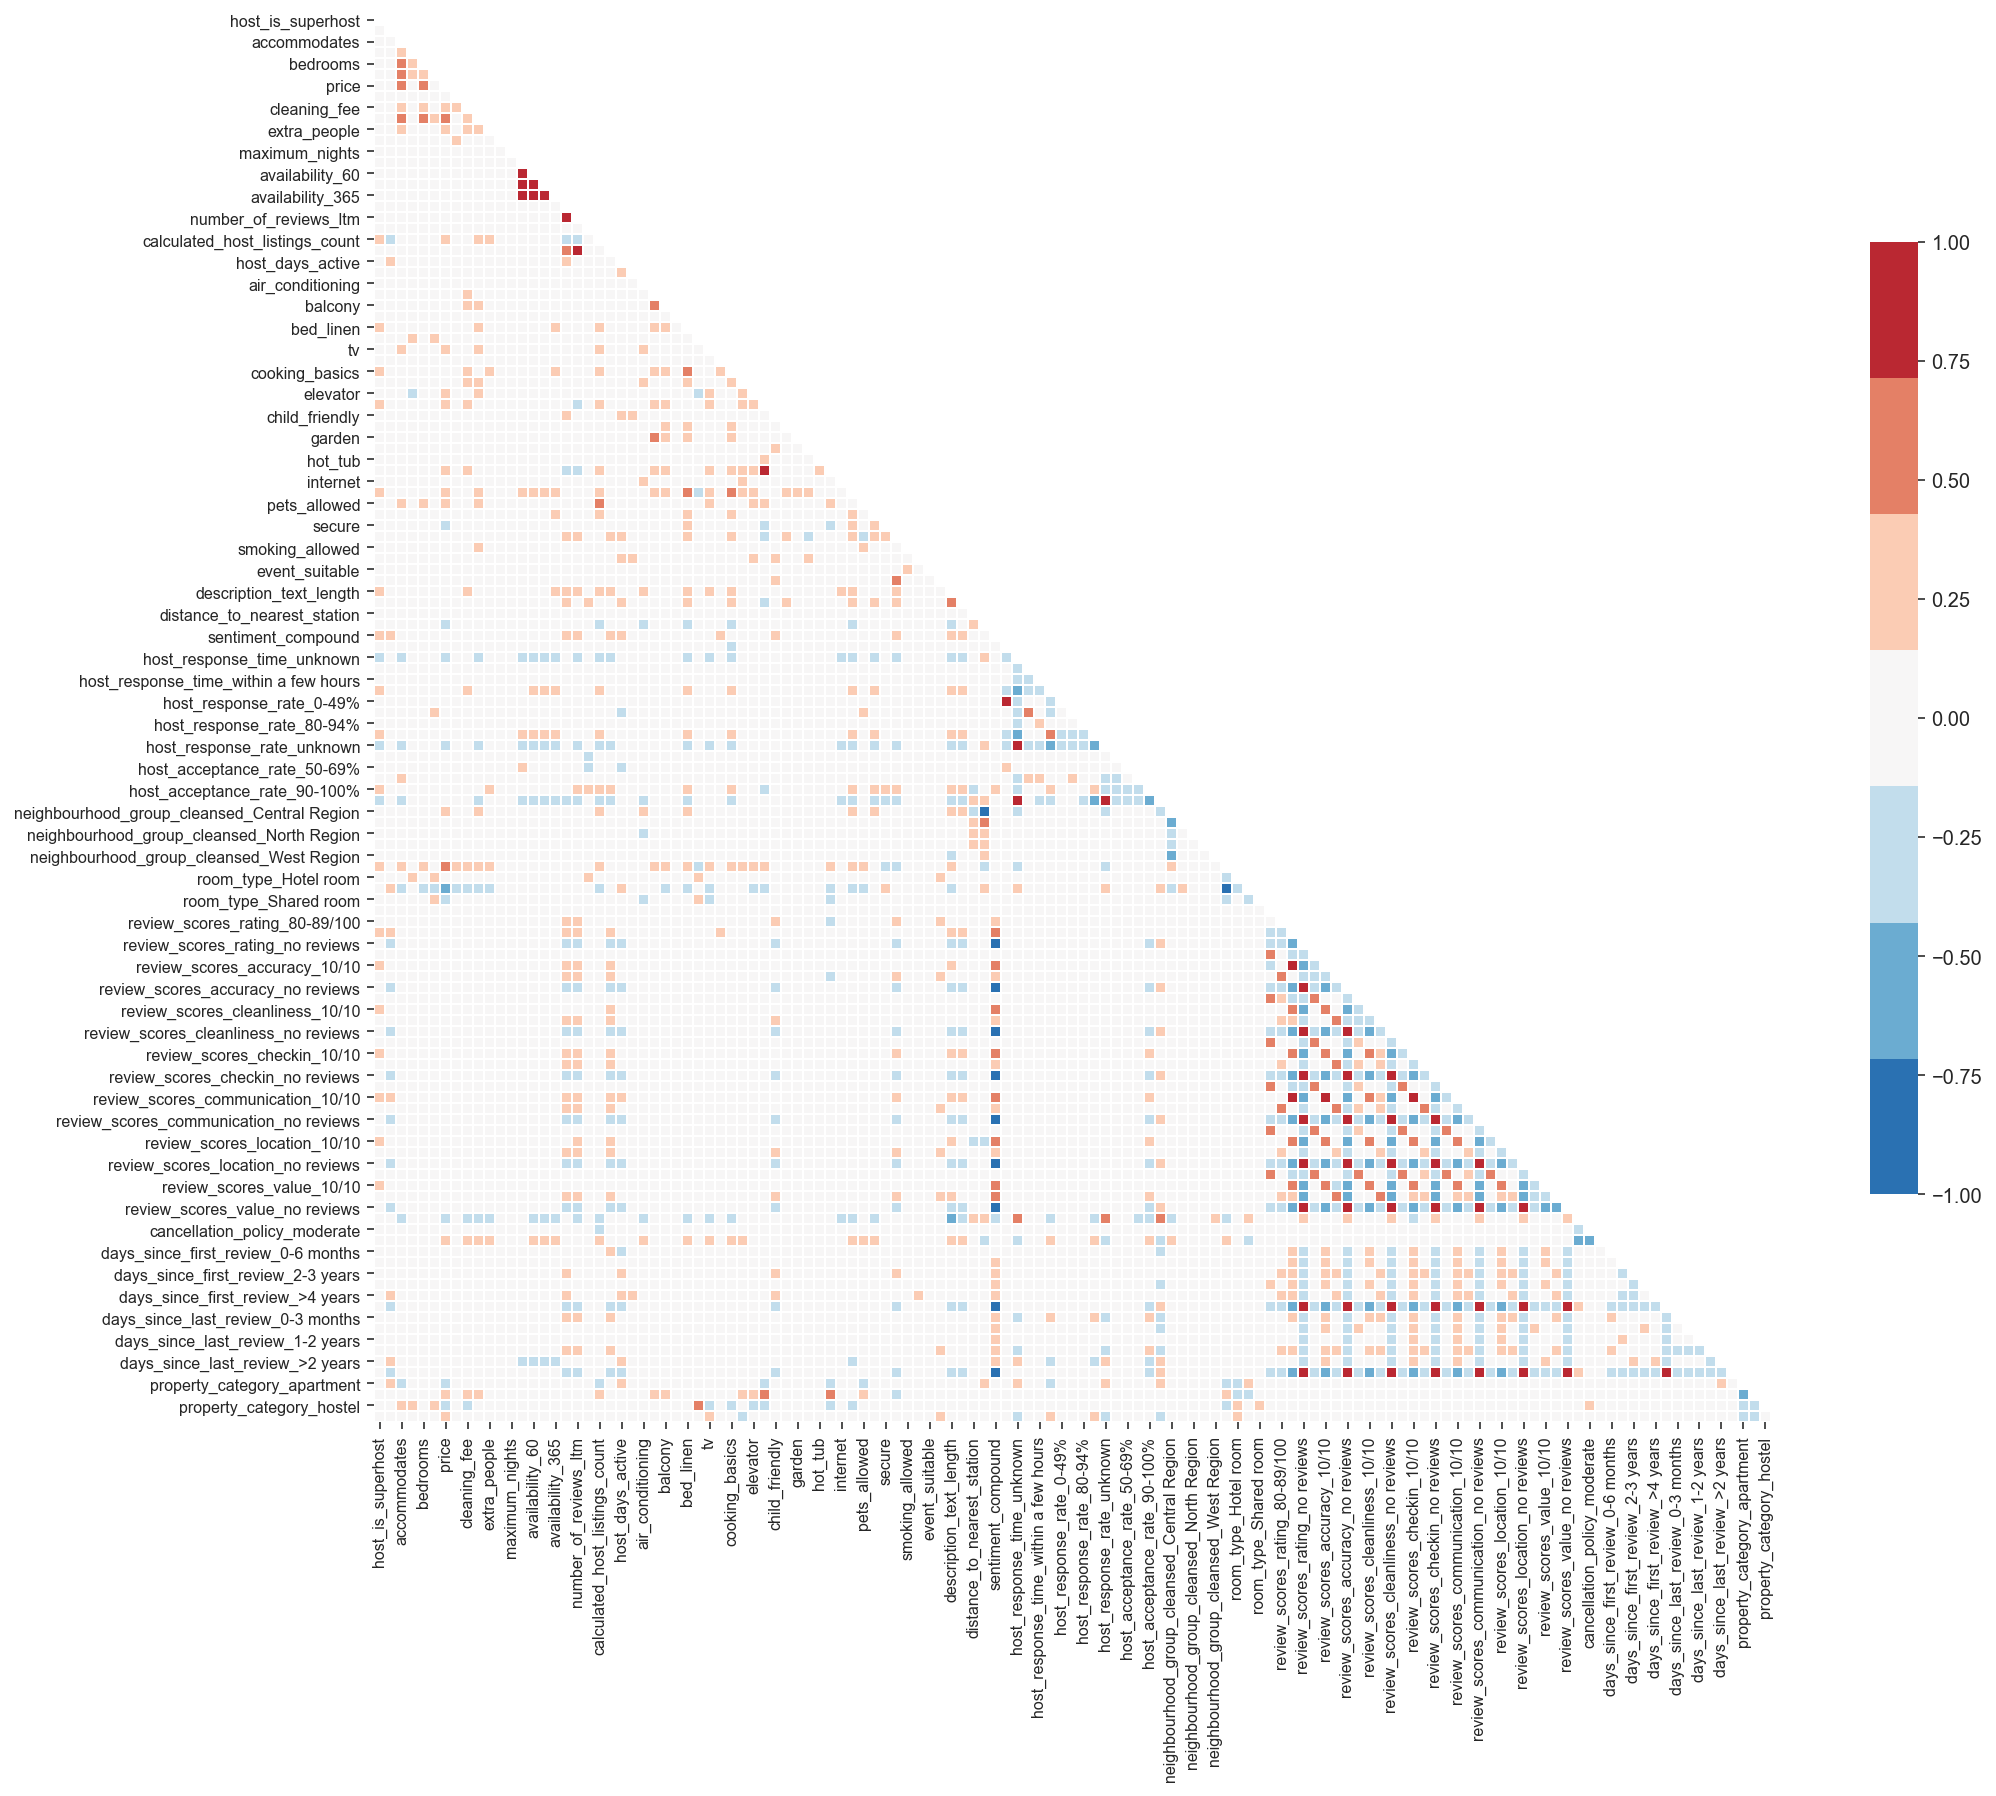

In [142]:
# Plot heatmap
mask = np.zeros_like(listings.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(listings.corr(),
            mask = mask,
            square=True,
            vmin = -1,
            vmax = 1,
            linewidth=0.5,
            cbar_kws = {'shrink':0.5},
            cmap=sns.color_palette("RdBu_r", 7))
ax.tick_params(labelsize=8)
plt.tight_layout()

#### Collinear features

In [143]:
# Check 'availability' features correlation
listings.corr()['availability_30'].sort_values(ascending = False).head()

availability_30               1.000000
availability_60               0.970728
availability_90               0.935282
availability_365              0.723469
host_response_rate_95-100%    0.169948
Name: availability_30, dtype: float64

In [144]:
# Check 'pool' features correlation
listings.corr()['pool'].sort_values(ascending = False).head(3)

pool                       1.000000
gym                        0.758635
property_category_condo    0.464416
Name: pool, dtype: float64

In [145]:
# Check 'number of reviews' features correlation
listings.corr()['number_of_reviews'].sort_values(ascending = False).head(3)

number_of_reviews        1.000000
number_of_reviews_ltm    0.715904
reviews_per_month        0.659877
Name: number_of_reviews, dtype: float64

In [146]:
# Check 'reviews scores' features correlation
listings.corr()['review_scores_rating_no reviews'].sort_values(ascending = False).head(10)

review_scores_rating_no reviews           1.000000
review_scores_cleanliness_no reviews      0.999102
review_scores_accuracy_no reviews         0.998504
review_scores_communication_no reviews    0.998504
review_scores_value_no reviews            0.997310
review_scores_checkin_no reviews          0.997310
review_scores_location_no reviews         0.997012
days_since_last_review_no reviews         0.960599
days_since_first_review_no reviews        0.960599
cancellation_policy_flexible              0.232273
Name: review_scores_rating_no reviews, dtype: float64

In [147]:
# Check 'host response time' features correlation
listings.corr()['host_response_time_unknown'].sort_values(ascending = False).head(3)

host_response_rate_unknown      1.000000
host_response_time_unknown      1.000000
host_acceptance_rate_unknown    0.752724
Name: host_response_time_unknown, dtype: float64

The availability features are highly correlated (correlation coeffcient >0.9) with each other. I will be keeping the availability in the next 30 days feature since price could be more dynamic for availability in the near term.   

There is close to perfect correlations between the different review score categories for the listings that are not reviewed yet, and first and last review times. Review categories with zero review entries will therefore be dropped.

The same is true of unknown host response rates and reponse times features. I will drop the unknown host response rate feature.

#### Correlation to listing price

In [149]:
# Top 10 features with positive correlation to listing price
listings.corr()[['price']].sort_values('price',ascending=False).head(10)

price
price                            1.000000
room_type_Entire home/apt        0.578555
guests_included                  0.505072
bedrooms                         0.496074
accommodates                     0.488632
tv                               0.379269
gym                              0.273216
cleaning_fee                     0.268733
property_category_svc_apt_hotel  0.259103
pool                             0.235994

In [150]:
# Top 10 features with negative correlation to listing price
listings.corr()[['price']].sort_values('price',ascending=True).head(10)

price
room_type_Private room       -0.518983
property_category_apartment  -0.236232
distance_to_city             -0.215308
property_category_hostel     -0.194839
room_type_Shared room        -0.181250
secure                       -0.154301
cancellation_policy_flexible -0.153346
host_response_rate_unknown   -0.151233
host_response_time_unknown   -0.151233
host_days_active             -0.139468

In [151]:
# Extract features with close to zero correlation to listing price (abs coefficient <0.05)
corr_price = abs(listings.corr()['price'])
features_drop = corr_price[corr_price < 0.05]
features_drop = features_drop.to_frame().index.tolist()
features_drop

['bathrooms',
 'maximum_nights',
 'number_of_reviews_ltm',
 'reviews_per_month',
 'check_in_24h',
 'nature_and_views',
 'coffee_machine',
 'washer',
 'parking',
 'garden',
 'host_greeting',
 'internet',
 'event_suitable',
 'building_staff',
 'host_response_time_a few days or more',
 'host_response_time_within a few hours',
 'host_response_time_within an hour',
 'host_response_rate_0-49%',
 'host_response_rate_95-100%',
 'host_acceptance_rate_0-49%',
 'host_acceptance_rate_90-100%',
 'room_type_Hotel room',
 'review_scores_rating_0-79/100',
 'review_scores_rating_90-100/100',
 'review_scores_accuracy_0-8/10',
 'review_scores_accuracy_10/10',
 'review_scores_cleanliness_10/10',
 'review_scores_cleanliness_9/10',
 'review_scores_checkin_0-8/10',
 'review_scores_checkin_9/10',
 'review_scores_communication_0-8/10',
 'review_scores_communication_9/10',
 'review_scores_location_0-8/10',
 'review_scores_location_10/10',
 'review_scores_value_0-8/10',
 'review_scores_value_9/10',
 'days_since_

In [152]:
listings.head(1)

host_is_superhost  host_identity_verified  accommodates  bathrooms  \
0                  0                       0             1        1.0   

   bedrooms  beds  price  security_deposit  cleaning_fee  guests_included  \
0       1.0   1.0   84.0               0.0           0.0                1   

   extra_people  minimum_nights  maximum_nights  availability_30  \
0          14.0             180             360               30   

   availability_60  availability_90  availability_365  number_of_reviews  \
0               60               90               365                  1   

   number_of_reviews_ltm  instant_bookable  calculated_host_listings_count  \
0                      0                 0                               2   

   reviews_per_month  host_days_active  check_in_24h  air_conditioning  bbq  \
0               0.01            3533.0           0.0               1.0  0.0   

   balcony  nature_and_views  bed_linen  breakfast   tv  coffee_machine  \
0      0.0               0.0        0.0        0.0  1.0             0.0   

   cooking_basics  washer  elevator  gym  child_friendly  parking  garden  \
0             0.0     1.0       1.0  0.0             0.0      0.0     0.0   

   host_greeting  hot_tub  pool  internet  long_term_stays  pets_allowed  \
0            0.0      0.0   0.0       1.0              0.0           1.0   

   private_entrance  secure  self_check_in  smoking_allowed  \
0               0.0     0.0            0.0              0.0   

   wheelchair_access  event_suitable  building_staff  description_text_length  \
0                0.0             0.0             0.0                      187   

   transit_text_length  distance_to_nearest_station  distance_to_city  \
0                    0                     0.570817         15.961311   

   sentiment_compound  host_response_time_a few days or more  \
0              0.9615                                      0   

   host_response_time_unknown  host_response_time_within a day  \
0                           0                                0   

   host_response_time_within a few hours  host_response_time_within an hour  \
0                                      0                                  1   

   host_response_rate_0-49%  host_response_rate_50-79%  \
0                         0                          0   

   host_response_rate_80-94%  host_response_rate_95-100%  \
0                          0                           1   

   host_response_rate_unknown  host_acceptance_rate_0-49%  \
0                           0                           0   

   host_acceptance_rate_50-69%  host_acceptance_rate_70-89%  \
0                            0                            0   

   host_acceptance_rate_90-100%  host_acceptance_rate_unknown  \
0                             0                             1   

   neighbourhood_group_cleansed_Central Region  \
0                                            0   

   neighbourhood_group_cleansed_East Region  \
0                                         0   

   neighbourhood_group_cleansed_North Region  \
0                                          1   

   neighbourhood_group_cleansed_North-East Region  \
0                                               0   

   neighbourhood_group_cleansed_West Region  room_type_Entire home/apt  \
0                                         0                          0   

   room_type_Hotel room  room_type_Private room  room_type_Shared room  \
0                     0                       1                      0   

   review_scores_rating_0-79/100  review_scores_rating_80-89/100  \
0                              0                               0   

   review_scores_rating_90-100/100  review_scores_rating_no reviews  \
0                                1                                0   

   review_scores_accuracy_0-8/10  review_scores_accuracy_10/10  \
0                              0                             1   

   review_scores_accuracy_9/10  review_scores_ac

#### Drop features with collinearity and close to zero correlation

In [153]:
# Drop collinear features
collinear_col = ['availability_60','availability_90','availability_365','host_response_rate_unknown','review_scores_accuracy_no reviews',
                'review_scores_cleanliness_no reviews','review_scores_checkin_no reviews','review_scores_communication_no reviews',
                'review_scores_location_no reviews','review_scores_value_no reviews','days_since_first_review_no reviews',
                'days_since_last_review_no reviews']    
listings.drop(columns = collinear_col, inplace=True)   

# Drop features with close to zero correlation (abs coeff < 0.05) 
listings.drop(columns = features_drop, inplace=True)  

In [154]:
listings.shape

(6973, 73)

## EDA Summary

From the above EDA, the top features that have a moderate linear relationship with the listing price based on the correlation coefficients (absolute magnitude of 0.21 to 0.58) include the accommodation type, number of people the accommodation can accommodate, number of bedrooms, presence of specific amenities e.g. TV, pool, gym, and distance to city. They would be potential strong predictors to the listing price. 

Listing prices generally trend higher for renting out entire home/ apartment which can accommodate more guests, accommodations with available TV, pool and gym, and those located near the city.

On the contrary, prices are generally lower for apartment or hostels listings and those that have flexible cancellation policies. It is also interesting to note that the listing price has a negative relationship with the number of days that the host has been on the Airbnb platform, suggesting that more experienced hosts tend to set prices which are competitive. 

## Final check

In [155]:
listings.columns

Index(['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'availability_30',
       'number_of_reviews', 'instant_bookable',
       'calculated_host_listings_count', 'host_days_active',
       'air_conditioning', 'bbq', 'balcony', 'bed_linen', 'breakfast', 'tv',
       'cooking_basics', 'elevator', 'gym', 'child_friendly', 'hot_tub',
       'pool', 'long_term_stays', 'pets_allowed', 'private_entrance', 'secure',
       'self_check_in', 'smoking_allowed', 'wheelchair_access',
       'description_text_length', 'transit_text_length',
       'distance_to_nearest_station', 'distance_to_city', 'sentiment_compound',
       'host_response_time_unknown', 'host_response_time_within a day',
       'host_response_rate_50-79%', 'host_response_rate_80-94%',
       'host_acceptance_rate_50-69%', 'host_acceptance_rate_70-89%',
       'host_acceptance_rate_unkn

In [156]:
# Rename column names to remove spaces, and lower case column
listings.columns = listings.columns.str.replace(' ', '_')

# lower case column names
listings.columns= listings.columns.str.lower()

In [157]:
# Save cleaned data to csv 
listings.to_csv('../data/listings_final.csv',index = False)